# PCA on Implied Volatility Surfaces: A Dimensionality Reduction Approach

## 1. **Motivation**

- Options prices are driven by different risk factors, primarily delta and implied volatility (IV).
- IV is not directly observable and encodes deviations from the assumed log-normal return distribution.
- Hedging IV-related risk requires understanding the covariance structure of IV movements.
- Challenges in estimating IV covariance matrices:
  - Measurement noise and bid-ask spreads.
  - Large dimensionality due to multiple strikes and expirations.

## 2. **A Proposed Solution: Dimensionality Reduction**

1. Reduce the dimensionality of the IV surface.
2. Compute the covariance matrix in reduced space.
3. Reconstruct a covariance matrix from the lower-rank factor structure.

## 3. **Simple PCA on Implied Volatility Surfaces**

### **Step 1: Data Acquisition & Preprocessing**

- Pull precomputed IV surfaces from the OptionMetrics database.
  - Identify data anomalies (e.g., IV discrepancies between puts and calls).
  - Justify using only out-of-the-money (OTM) options due to tighter spreads.
  - Discuss the OptionMetrics methodology for generating IV values.
- **Visualization:**
  - 3D plot of IV values interpolated across time-to-maturity and delta.

### **Step 2: IV Surface Exploration**

- Show IV curves across multiple dates and products.
- Identify common patterns in IV movements.

### **Step 3: Running PCA on IV Data**

- Construct the IV data matrix for PCA.
- **PCA component interpretation:**
  - First component: Level shifts.
  - Second component: Skew (slope).
  - Third component: Kurtosis (curvature).
  - Fourth component: Higher-order effects.
- **Efficiency considerations:**
  - Compare true SVD vs. randomized SVD implementations.
- **Weighting considerations:**
  - Should we use Vega-weighted covariance matrices?
  - Would results be more generalizable in IV space, applying Vega-weighting only in risk applications?

### **Step 4: Risk Adjustment Using Factor Structure**

1. Compute the covariance matrix in factor space.
2. **Position Visualization:**
   - Heat map of raw risk exposure.
3. **Factor-Based Decomposition:**
   - Show how individual options load onto PCA factors.
   - Aggregate portfolio risk in factor space.
4. **Covariance-Adjusted Risk View:**
   - Convert factor exposures to covariance-adjusted risk.
   - Plot reconstructed portfolio risk.

### **Step 5: Recap and Takeaways**

- The importance of starting with **IV data interpolated onto a consistent delta & time-to-maturity grid**.
- How PCA provides a **simplified view of IV risk**.
- How this approach stabilizes covariance estimates and enables better hedging.

## 4. **Extensions Beyond PCA**

### **1) Functional PCA (FPCA)**

- Parameterizes IV as a function of delta and time-to-maturity.
- Captures additional covariance information between nearby points.

### **2) Instrumented PCA (IPCA)**

- IPCA extends traditional PCA by allowing factor loadings to depend on observable characteristics.
- This enables dynamic adjustments in factor structures based on exogenous variables such as earnings risks, dividend risks, and macroeconomic indicators.
- For example, implied volatility surfaces may exhibit different factor structures around earnings announcements due to shifts in uncertainty and investor sentiment.
- By conditioning on these variables, IPCA provides a more flexible decomposition of implied volatility risk.
- A key question: Can lagged IV surfaces serve as relevant instruments to capture time-dependent market behavior?

### **3) Autoencoders for IV Decomposition**

- Captures nonlinear relationships in IV dynamics.
- Analogous to feature extraction in IV space, allowing for capturing latent structures beyond simple linear factors.

### **4) Transformer-Based IV Modeling**

- Generates potential future IV surfaces in a time-series setting.
- Would transformers be used to predict future IV surfaces, classify market regimes, or generate factor embeddings? How should tokenization, attention, and training mechanisms be designed?

## 5. **Open Questions & Further Considerations**

- How do alternative decomposition methods compare in practice?
- What do we lose in **linearity and portfolio construction properties** when using nonlinear models (FPCA, IPCA, Autoencoders, Transformers)?
- Should PCA be performed in IV space or Vega-weighted space?
- How do PCA-based risk models compare to industry-standard approaches?

#### **Task List for Implementing PCA on IV Surfaces in a Jupyter Notebook**

##### **1. Data Preparation**

- Load precomputed IV surfaces from the OptionMetrics database.
- Identify and handle missing or anomalous IV data (e.g., mismatches between put/call IVs).
- Select a subset of options:
  - Focus on OTM options due to tighter bid-ask spreads.
  - Filter options based on liquidity and time-to-maturity thresholds.
- Interpolate IV onto a structured grid:
  - Convert strikes to deltas for a standardized moneyness measure.
  - Interpolate IV values across time-to-maturity and delta dimensions.

##### **2. Data Exploration & Visualization**

- Generate 3D surface plots of IV against delta and time-to-maturity.
- Create time-series plots of IV for different moneyness levels.
- Show IV distributions across maturities to visualize common patterns.
- Examine IV autocorrelation across time and strike price.

##### **3. Construct Data Matrix for PCA**

- Define the data matrix where:
  - Rows correspond to different dates.
  - Columns correspond to IV values for different (delta, time-to-maturity) grid points.
- Normalize the data:
  - Consider standardizing IV values (subtract mean, divide by standard deviation) for better PCA performance.
  - Decide whether to use raw IV values or Vega-weighted IV values.

##### **4. Perform PCA**

- Compute PCA using Singular Value Decomposition (SVD) or a randomized SVD method for efficiency.
- Determine the optimal number of principal components using:
  - Explained variance ratio plots (scree plots).
  - Cumulative variance explained.
- Store factor loadings and principal component scores for later use.

##### **5. Interpret PCA Components**

- Visualize the first few principal components:
  - Plot the first 3-4 components across delta and time-to-maturity.
  - Compare these components to known IV movements (level, skew, curvature).
- Analyze time-series of factor scores:
  - Observe correlations with market volatility indices (e.g., VIX).
  - Detect regime shifts and patterns in factor dynamics.

##### **6. Efficiency Considerations**

- Compare computation time of different PCA implementations:
  - Full SVD vs. truncated SVD vs. randomized SVD.
- Optimize memory usage for handling large IV datasets.

##### **7. Weighting Considerations**

- Vega weight before PCA transform so we're dealing with dollar numinaire variance.

##### **8. Develop Functions for Reproducibility**

- **`load_iv_data()`**: Load and preprocess IV data from OptionMetrics.
- **`interpolate_iv_surface()`**: Interpolate IV onto a structured (delta, time-to-maturity) grid.
- **`visualize_iv_surfaces()`**: Generate 3D plots and time-series IV visualizations.
- **`construct_pca_matrix()`**: Format the IV dataset into a matrix for PCA.
- **`run_pca()`**: Compute PCA using efficient decomposition methods.
- **`plot_pca_components()`**: Visualize principal components across delta/maturity.
- **`analyze_pca_scores()`**: Examine factor score time-series and correlations.


In [56]:
import glob
import time
import zipfile
import numpy as np
import pandas as pd
import scipy.ndimage
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA
from tqdm import tqdm

tqdm.pandas()

In [57]:
# Check if the CSV files already exist
if not glob.glob('testForwards/*.csv'):
  with zipfile.ZipFile('testForwards.zip', 'r') as zip_ref:
    zip_ref.extractall('testForwards')

if not glob.glob('testOptionsIV/*.csv'):
  with zipfile.ZipFile('testOptionsIV.zip', 'r') as zip_ref:
    zip_ref.extractall('testOptionsIV')
    
options_test_read = pd.read_csv(glob.glob('testOptionsIV/*.csv')[0], nrows=3)
forwards_test_read = pd.read_csv(glob.glob('testForwards/*.csv')[0], nrows=3)
display(list(enumerate(options_test_read.columns)), list(enumerate(forwards_test_read.columns)))

[(0, 'secid'),
 (1, 'date'),
 (2, 'days'),
 (3, 'delta'),
 (4, 'impl_volatility'),
 (5, 'impl_strike'),
 (6, 'impl_premium'),
 (7, 'dispersion'),
 (8, 'cp_flag'),
 (9, 'cusip'),
 (10, 'ticker'),
 (11, 'index_flag'),
 (12, 'exchange_d'),
 (13, 'class'),
 (14, 'issue_type'),
 (15, 'industry_group')]

[(0, 'secid'),
 (1, 'date'),
 (2, 'expiration'),
 (3, 'AMSettlement'),
 (4, 'ForwardPrice'),
 (5, 'cusip'),
 (6, 'ticker'),
 (7, 'sic'),
 (8, 'index_flag'),
 (9, 'exchange_d'),
 (10, 'class'),
 (11, 'issue_type'),
 (12, 'industry_group'),
 (13, 'issuer')]

In [58]:


# Read the CSV files
forwards_df = pd.read_csv(glob.glob('testForwards/*.csv')[0] , usecols=[1,2,4,6]) # 'date', 'ForwardPrice', 'ticker', 'expiration'
options_iv_df = pd.read_csv(glob.glob('testOptionsIV/*.csv')[0], usecols=[1,2,3,4,8,10]) # 'date', 'days', 'delta', 'impl_volatility', 'cp_flag', 'ticker'

forwards_df['date'] = pd.to_datetime(forwards_df['date'])
forwards_df['expiration'] = pd.to_datetime(forwards_df['expiration'])
forwards_df['days'] = (forwards_df['expiration'] - forwards_df['date']).dt.days

options_iv_df['date'] = pd.to_datetime(options_iv_df['date'])
options_iv_df.loc[options_iv_df.cp_flag == "P", 'delta'] = options_iv_df.loc[options_iv_df.cp_flag == "P", "delta"] + 100

forwards_df.drop(columns=['expiration'], inplace=True)

# Define the date range
start_date = '2015-01-01'
end_date = '2018-01-01'

# Filter the dataframes based on the date range
forwards_df = forwards_df[(forwards_df['date'] >= start_date) & (forwards_df['date'] <= end_date)]
options_iv_df = options_iv_df[(options_iv_df['date'] >= start_date) & (options_iv_df['date'] <= end_date)]


In [59]:
# Display the dataframes
forwards_df.shape, forwards_df.columns

((93590, 4), Index(['date', 'ForwardPrice', 'ticker', 'days'], dtype='object'))

In [60]:
options_iv_df.shape, options_iv_df.columns

((2258960, 6),
 Index(['date', 'days', 'delta', 'impl_volatility', 'cp_flag', 'ticker'], dtype='object'))

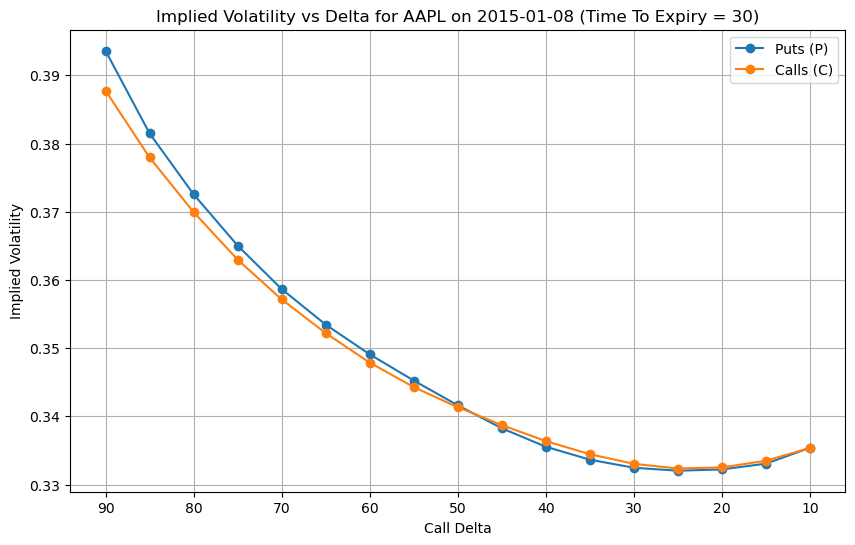

In [61]:

date = '2015-01-08'
days_filter = 30
ticker = 'AAPL'
appl_single_day = options_iv_df.loc[(options_iv_df.ticker == ticker) & (options_iv_df.date == date)].dropna()

# Filter data for puts and calls based on 'days'
puts = appl_single_day[(appl_single_day['cp_flag'] == 'P') & (appl_single_day['days'] == days_filter)].copy()
calls = appl_single_day[(appl_single_day['cp_flag'] == 'C') & (appl_single_day['days'] == days_filter)]

# Adjust delta for puts
# puts['delta'] = puts['delta'] + 100

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(puts['delta'], puts['impl_volatility'], label='Puts (P)', marker='o')
plt.plot(calls['delta'], calls['impl_volatility'], label='Calls (C)', marker='o')

plt.xlabel('Call Delta')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatility vs Delta for AAPL on {date} (Time To Expiry = {days_filter})')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # Reverse the x-axis direction
plt.show()

In [62]:

d1_cache = {delta : norm.ppf(delta/100) for delta in range(1, 101)}
time_moneyness_cache = {}

def calculate_vega(row):
    days = row['days']
    delta = row['delta']
    fwd = row['fwd']
    d1 = d1_cache[delta] if delta in d1_cache else norm.ppf(delta/100)
    if (d1,days) not in time_moneyness_cache:
        time_moneyness_cache[(d1,days)] = norm.pdf(d1)*np.sqrt(days/365)
    time_moneyness = time_moneyness_cache[(d1,days)]   
    vega = fwd*time_moneyness
    return vega

def precompute_forward_prices(forwards_df, unique_days):
    """
    Precomputes interpolated forward prices for each (date, ticker) combination 
    based on the given unique days in the options data.

    Parameters:
        forwards_df (pd.DataFrame): DataFrame containing forward prices with columns ['date', 'ForwardPrice', 'ticker', 'days']
        unique_days (np.array): Unique days to maturity from the options data.

    Returns:
        dict: A dictionary where keys are (date, ticker) pairs, and values are dictionaries mapping days to interpolated prices.
    """
    precomputed_values = {}

    for (date, ticker), group in forwards_df.groupby(['date', 'ticker']):
        group = group.sort_values(by="days")
        if len(group) > 1:
            interp_prices = np.interp(unique_days, group["days"], group["ForwardPrice"])
        else:
            interp_prices = np.full_like(unique_days, group["ForwardPrice"].values[0], dtype=np.float64)
        
        precomputed_values[(date, ticker)] = dict(zip(unique_days, interp_prices))

    return precomputed_values

def assign_forward_prices(options_iv_df, precomputed_values):
    """
    Assigns interpolated forward prices to the options data based on the precomputed values.

    Parameters:
        options_iv_df (pd.DataFrame): DataFrame containing options implied volatility data.
        precomputed_values (dict): Dictionary of precomputed forward prices.

    Returns:
        pd.DataFrame: options_iv_df with a new column 'ForwardPrice'.
    """
    options_iv_df["fwd"] = options_iv_df.progress_apply(
        lambda row: precomputed_values.get((row["date"], row["ticker"]), {}).get(row["days"], np.nan), axis=1
    )
    return options_iv_df

def plot_heatmap(index_mapped_data, title, is_int=False, show_values=True, scale=None, save=None):
  unstacked_data = index_mapped_data.unstack()
  max_abs_value = np.abs(unstacked_data.values).max()
  if scale is None:
    scale = (-max_abs_value, max_abs_value)
  plt.figure(figsize=(12, 8))
  sns.heatmap(unstacked_data, cmap='coolwarm', annot=show_values, fmt="d" if is_int else '.2f', vmin=scale[0], vmax=scale[1])
  plt.title(title)
  plt.xlabel('Delta')
  plt.ylabel('Days')
  plt.gca().invert_yaxis()  # Reverse the y-axis direction
  plt.gca().invert_xaxis()  # Reverse the x-axis direction
  if save:
    plt.savefig(save, format='png')
  plt.show()

# Get unique days from options_iv_df
unique_days = np.array(options_iv_df['days'].unique())

# Step 1: Precompute interpolated forward prices
precomputed_values = precompute_forward_prices(forwards_df, unique_days)

# Step 2: Assign interpolated forward prices to options_iv_df
options_iv_df = assign_forward_prices(options_iv_df, precomputed_values)



100%|██████████| 2258960/2258960 [00:23<00:00, 96458.55it/s] 


In [63]:
options_iv_df[(options_iv_df.date == '2015-01-02') & (options_iv_df.ticker == 'AAPL') & (options_iv_df.cp_flag == 'C') & (options_iv_df.delta == 50)]

date  days  delta  impl_volatility cp_flag ticker         fwd
4449503 2015-01-02    10     50         0.271018       C   AAPL  109.322249
4449537 2015-01-02    30     50         0.333749       C   AAPL  109.186299
4449571 2015-01-02    60     50         0.317160       C   AAPL  108.900535
4449605 2015-01-02    91     50         0.301335       C   AAPL  108.926427
4449639 2015-01-02   122     50         0.300368       C   AAPL  108.869965
4449673 2015-01-02   152     50         0.301129       C   AAPL  108.748853
4449707 2015-01-02   182     50         0.302305       C   AAPL  108.627742
4449741 2015-01-02   273     50         0.305677       C   AAPL  108.292979
4449775 2015-01-02   365     50         0.306559       C   AAPL  108.013947
4449809 2015-01-02   547     50         0.310340       C   AAPL  107.809666
4449843 2015-01-02   730     50         0.315839       C   AAPL  107.629691

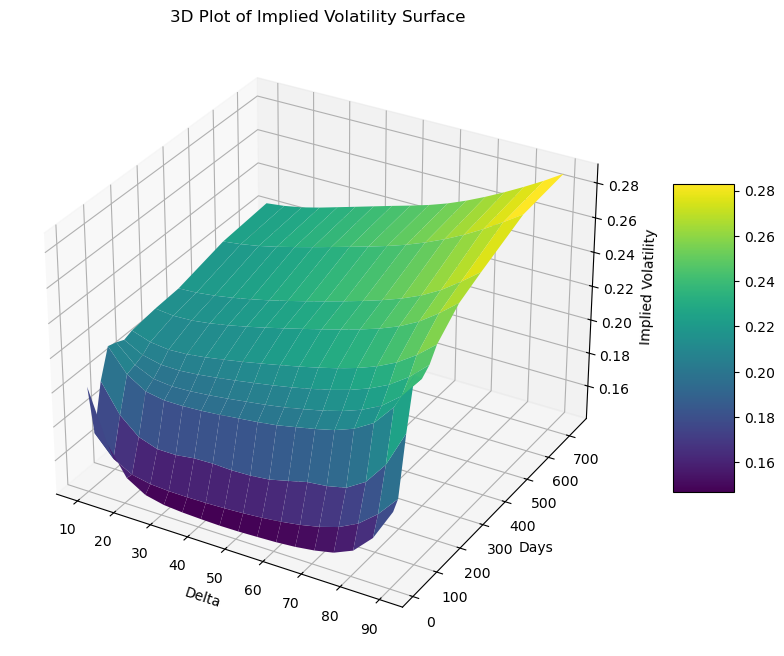

In [64]:


# Unstack the sample_surface to get a DataFrame
sample_surface_df = sample_surface.unstack()

# Create meshgrid for plotting
X, Y = np.meshgrid(sample_surface_df.columns, sample_surface_df.index)
Z = sample_surface_df.values

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Labels and title
ax.set_xlabel('Delta')
ax.set_ylabel('Days')
ax.set_zlabel('Implied Volatility')
ax.set_title('3D Plot of Implied Volatility Surface')

plt.show()

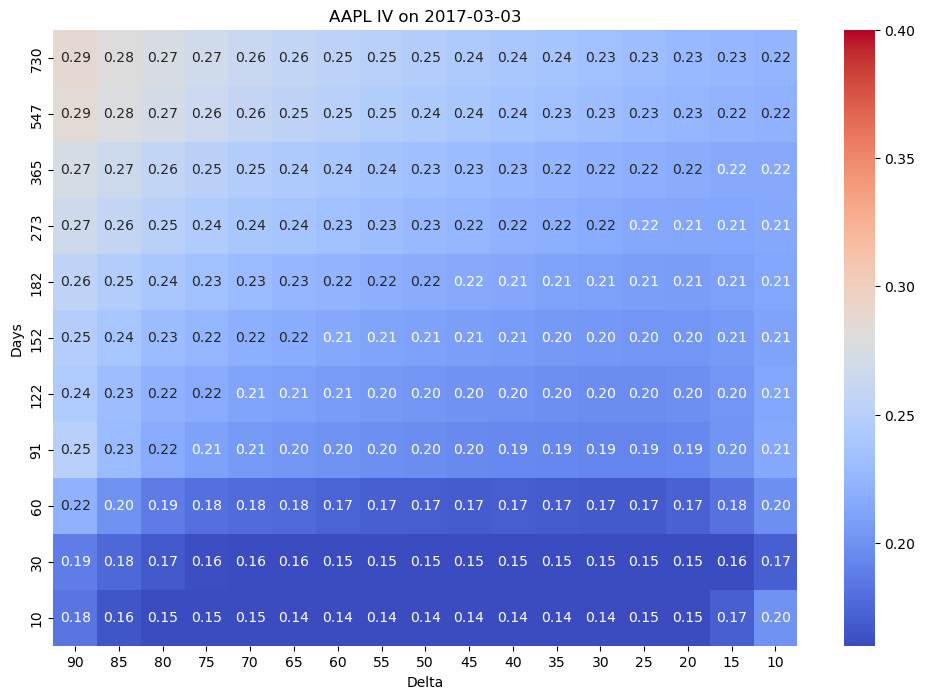

In [65]:
date = "2017-03-03"
scale = (.16, .4)
sample_surface = options_iv_df[(options_iv_df.ticker=='AAPL') & (options_iv_df.date == date)].groupby(['delta', 'days'])['impl_volatility'].mean().unstack().unstack()
plot_heatmap(sample_surface, f"AAPL IV on {date}", scale=scale, save=f'./pics/aapl_surface.png')

$\Phi(x,y,z) = \frac{1}{\sqrt{2\pi}} \exp \left( -\left[ \frac{x^2}{2h} + \frac{y^2}{2h} + \frac{z^2}{2h} \right] \right)$


In [66]:
# Filter options_iv_df to only include rows where ticker is AAPL
aapl_iv_df = options_iv_df[options_iv_df['ticker'] == 'AAPL'].copy()

# Drop rows where days == 10
aapl_iv_df = aapl_iv_df[aapl_iv_df['days'] != 10]
aapl_iv_df['vega'] = aapl_iv_df.progress_apply(calculate_vega, axis=1)
aapl_iv_df['dollar_vol'] = aapl_iv_df['vega'] * aapl_iv_df['impl_volatility']

# Group by date and delta, then calculate the average implied volatility
aapl_iv_grouped = aapl_iv_df.groupby(['date', 'delta', 'days'])['dollar_vol'].mean().unstack().unstack().diff().dropna()

# Flatten the DataFrame such that there's a unique column for every delta value
aapl_iv_flattened = aapl_iv_grouped.reset_index()

# Display the resulting DataFrame
aapl_iv_flattened.set_index(aapl_iv_flattened.columns[0], inplace=True)
aapl_iv_flattened

100%|██████████| 256700/256700 [00:02<00:00, 95198.33it/s] 


days              30                                                    \
delta             10        15        20        25        30        35   
(date, )                                                                 
2015-01-05  0.076798  0.110219  0.142193  0.171552  0.197383  0.220115   
2015-01-06  0.002574  0.014849  0.040318  0.063628  0.074489  0.076237   
2015-01-07 -0.023506 -0.037203 -0.057785 -0.075806 -0.084996 -0.087266   
2015-01-08 -0.017044 -0.022850 -0.022340 -0.022126 -0.025048 -0.029547   
2015-01-09  0.018050  0.035700  0.044698  0.048233  0.053323  0.061745   
...              ...       ...       ...       ...       ...       ...   
2017-12-22 -0.019871  0.021120  0.027749  0.027841  0.025231  0.019696   
2017-12-26  0.436754  0.517678  0.503938  0.497292  0.520674  0.552950   
2017-12-27 -0.071444 -0.065894 -0.036040 -0.009639  0.001821  0.007123   
2017-12-28 -0.007676  0.015536  0.021458  0.011547  0.001779 -0.008684   
2017-12-29 -0.366189 -0.238569 -0.074390  0.012058  0.039268  0.058774   

days                                                ...       730            \
delta             40        45        50        55  ...        45        50   
(date, )                                            ...                       
2015-01-05  0.239375  0.254226  0.264158  0.270934  ... -0.066318 -0.014735   
2015-01-06  0.074180  0.070690  0.067024  0.062834  ...  0.456658  0.479406   
2015-01-07 -0.087620 -0.088237 -0.086259 -0.081223  ...  0.338389  0.305055   
2015-01-08 -0.032573 -0.032538 -0.032723 -0.035130  ...  0.380911  0.375688   
2015-01-09  0.069797  0.075057  0.078513  0.082253  ...  0.078049  0.113754   
...              ...       ...       ...       ...  ...       ...       ...   
2017-12-22  0.012275  0.000298 -0.011665 -0.012925  ...  0.136363  0.107393   
2017-12-26  0.573680  0.587179  0.601385  0.589741  ... -0.724982 -0.731855   
2017-12-27  0.010794  0.020176  0.034207  0.047381  ...  0.106872  0.048417   
2017-12-28 -0.020873 -0.033720 -0.039997 -0.043781  ... -0.001095  0.010121   
2017-12-29  0.094942  0.127727  0.149288  0.172249  ... -0.638956 -0.543511   

days                                                                    \
delta             55        60        65        70        75        80   
(date, )                                                                 
2015-01-05 -0.007059 -0.054284 -0.110850 -0.125604 -0.088457 -0.018920   
2015-01-06  0.498426  0.530752  0.561401  0.564232  0.529535  0.466790   
2015-01-07  0.278965  0.269290  0.266541  0.260925  0.255105  0.238702   
2015-01-08  0.361247  0.358326  0.380282  0.394270  0.370799  0.314795   
2015-01-09  0.150389  0.184066  0.205374  0.205078  0.183970  0.155717   
...              ...       ...       ...       ...       ...       ...   
2017-12-22  0.066703  0.030339 -0.021826 -0.104850 -0.187236 -0.213376   
2017-12-26 -0.667872 -0.586836 -0.521135 -0.463330 -0.420448 -0.414218   
2017-12-27 -0.044879 -0.079919 -0.036988 -0.000153 -0.026627 -0.071996   
2017-12-28 -0.018762 -0.095756 -0.170695 -0.194142 -0.156948 -0.097985   
2017-12-29 -0.422613 -0.322240 -0.227583 -0.110394  0.009108  0.140969   

days                            
delta             85        90  
(date, )                        
2015-01-05  0.038334  0.051192  
2015-01-06  0.390208  0.292228  
2015-01-07  0.187234  0.105602  
2015-01-08  0.264146  0.235462  
2015-01-09  0.141947  0.140850  
...              ...       ...  
2017-12-22 -0.158388 -0.056586  
2017-12-26 -0.435682 -0.436585  
2017-12-27 -0.089227 -0.101779  
2017-12-28 -0.072667 -0.087255  
2017-12-29  0.348899  0.574301  

[754 rows x 170 columns]

In [67]:

K=10
# Run PCA
pca = PCA(n_components=K)
pca.fit(aapl_iv_flattened)
factor_loadings = pca.fit_transform(aapl_iv_flattened)
explained_variance_ratio = pca.explained_variance_ratio_
B = pca.components_.T


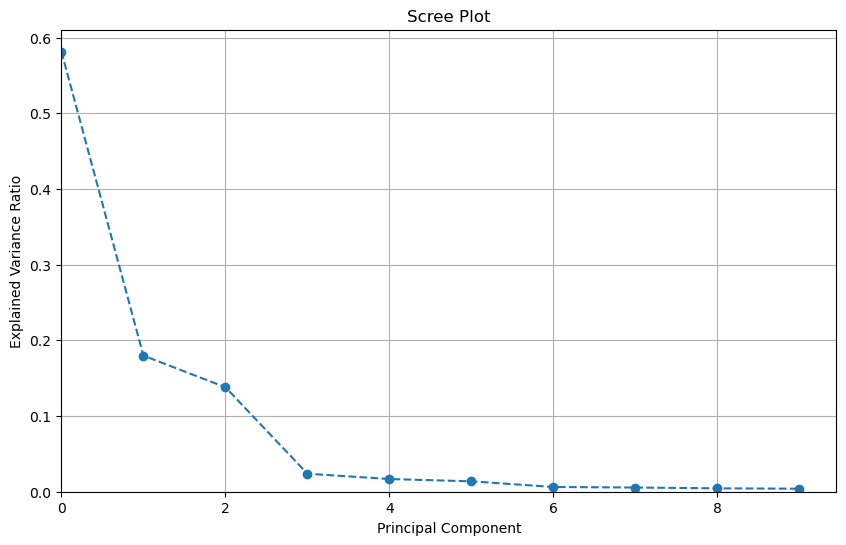

In [68]:

# Generate scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.title('Scree Plot')
plt.grid(True)
plt.show()

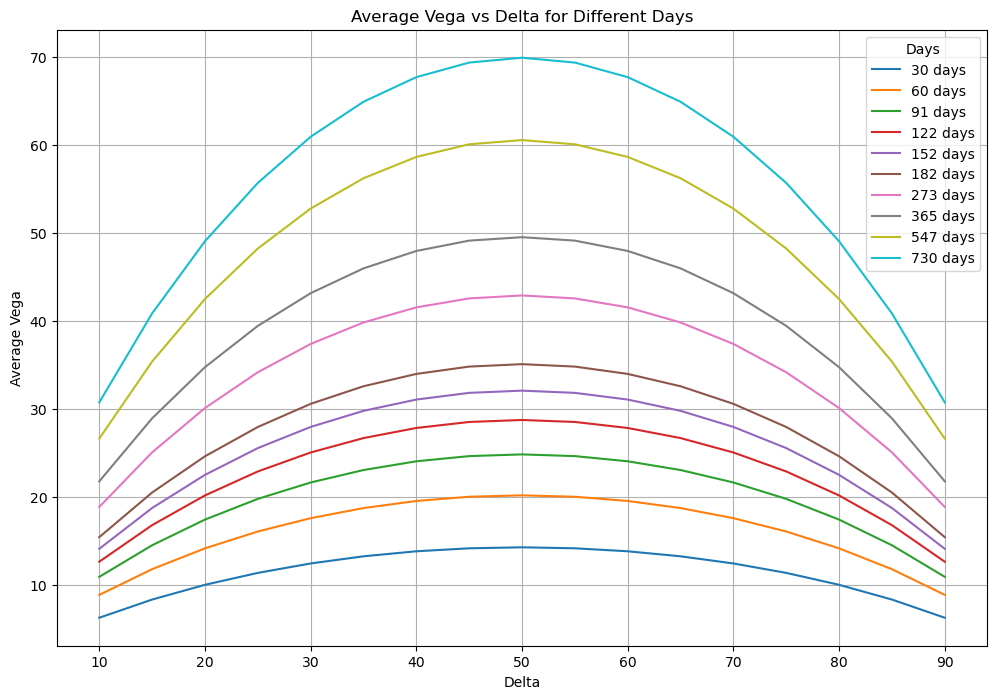

In [69]:
# Group by days and delta, then calculate the average vega
average_vega = aapl_iv_df.groupby(['days', 'delta'])['vega'].mean().unstack()

# Plot the data
plt.figure(figsize=(12, 8))
for days in average_vega.index:
  plt.plot(average_vega.columns, average_vega.loc[days], label=f'{days} days')

plt.xlabel('Delta')
plt.ylabel('Average Vega')
plt.title('Average Vega vs Delta for Different Days')
plt.legend(title='Days')
plt.grid(True)
plt.show()

In [70]:
cov = np.array([[1, -.7], [-.7, 1]])
pos = np.array([[2], [2]])
result = pos.T @ cov @ pos
print(result)

# np.linalg.inv(aapl_iv_flattened.cov())

[[2.4]]


In [71]:
cov_matrix = np.cov(aapl_iv_flattened.T)
cov_df = pd.DataFrame(cov_matrix, index=aapl_iv_flattened.columns, columns=aapl_iv_flattened.columns)

In [72]:
cov_df

days              30                                                    \
delta             10        15        20        25        30        35   
days delta                                                               
30   10     0.025402  0.024504  0.021265  0.019779  0.019952  0.020556   
     15     0.024504  0.025816  0.024653  0.024429  0.025363  0.026536   
     20     0.021265  0.024653  0.026071  0.027536  0.029365  0.031113   
     25     0.019779  0.024429  0.027536  0.030266  0.032853  0.035102   
     30     0.019952  0.025363  0.029365  0.032853  0.036009  0.038688   
...              ...       ...       ...       ...       ...       ...   
730  70     0.001930  0.004445  0.007352  0.009793  0.011549  0.012912   
     75     0.000995  0.003645  0.006719  0.009314  0.011208  0.012685   
     80    -0.000028  0.002879  0.006239  0.009109  0.011247  0.012929   
     85    -0.002425  0.000860  0.004760  0.008057  0.010495  0.012411   
     90    -0.005943 -0.002440  0.001893  0.005426  0.007944  0.009899   

days                                                ...       730            \
delta             40        45        50        55  ...        45        50   
days delta                                          ...                       
30   10     0.021067  0.021282  0.021139  0.020652  ...  0.005350  0.005173   
     15     0.027517  0.028117  0.028267  0.027968  ...  0.006845  0.006962   
     20     0.032542  0.033525  0.033998  0.033938  ...  0.008326  0.008792   
     25     0.036905  0.038199  0.038928  0.039053  ...  0.009601  0.010352   
     30     0.040818  0.042365  0.043294  0.043563  ...  0.010509  0.011475   
...              ...       ...       ...       ...  ...       ...       ...   
730  70     0.014025  0.014902  0.015582  0.016119  ...  0.051269  0.053225   
     75     0.013906  0.014898  0.015696  0.016358  ...  0.046617  0.048965   
     80     0.014341  0.015525  0.016514  0.017371  ...  0.041032  0.043948   
     85     0.014041  0.015437  0.016632  0.017724  ...  0.034391  0.037806   
     90     0.011583  0.013044  0.014316  0.015542  ...  0.026448  0.029892   

days                                                                    \
delta             55        60        65        70        75        80   
days delta                                                               
30   10     0.005025  0.004421  0.003229  0.001930  0.000995 -0.000028   
     15     0.007109  0.006719  0.005648  0.004445  0.003645  0.002879   
     20     0.009270  0.009170  0.008346  0.007352  0.006719  0.006239   
     25     0.011112  0.011257  0.010627  0.009793  0.009314  0.009109   
     30     0.012461  0.012787  0.012278  0.011549  0.011208  0.011247   
...              ...       ...       ...       ...       ...       ...   
730  70     0.054768  0.055855  0.056316  0.055943  0.054588  0.052121   
     75     0.050931  0.052447  0.053607  0.054588  0.055250  0.054905   
     80     0.046503  0.048462  0.050086  0.052121  0.054905  0.057583   
     85     0.040922  0.043354  0.045397  0.048124  0.052443  0.058122   
     90     0.033151  0.035831  0.038176  0.041177  0.045944  0.053189   

days                            
delta             85        90  
days delta                      
30   10    -0.002425 -0.005943  
     15     0.000860 -0.002440  
     20     0.004760  0.001893  
     25     0.008057  0.005426  
     30     0.010495  0.007944  
...              ...       ...  
730  70     0.048124  0.041177  
     75     0.052443  0.045944  
     80     0.058122  0.053189  
     85     0.063051  0.061897  
     90     0.061897  0.065710  

[170 rows x 170 columns]

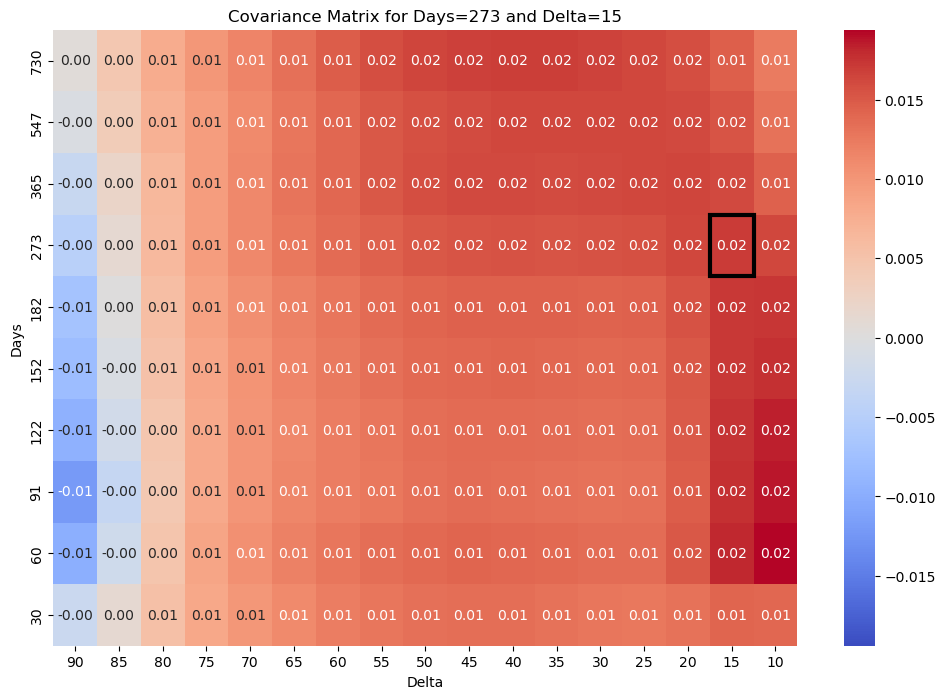

In [73]:
days_idx = 273
delta_idx = 15

def plot_single_option_covariance(cov_df, days_idx, delta_idx, scale=None):
  singlge_option_cov_df = cov_df[(days_idx, delta_idx)]
  if scale is None:
    max_val = singlge_option_cov_df.abs().max()
    scale = (-max_val, max_val)
  component_stacked = pd.DataFrame(singlge_option_cov_df, index=cov_df.columns).stack(future_stack=True)
  heatmap_data = component_stacked.unstack(level=1)
  heatmap_data.index = heatmap_data.index.droplevel(1)
  heatmap_data.columns = heatmap_data.columns.droplevel(0)

  plt.figure(figsize=(12, 8))
  ax = sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", vmin=scale[0], vmax=scale[1])

  # Highlight the cell corresponding to the given indices
  patch_idx = heatmap_data.columns.get_loc(delta_idx), heatmap_data.index.get_loc(days_idx)
  ax.add_patch(plt.Rectangle(patch_idx, 1, 1, fill=False, edgecolor='Black', lw=3))

  plt.title(f'Covariance Matrix for Days={days_idx} and Delta={delta_idx}')
  plt.xlabel('Delta')
  plt.ylabel('Days')
  plt.gca().invert_yaxis()  # Reverse the y-axis direction
  plt.gca().invert_xaxis()  # Reverse the x-axis direction
  plt.show()

# Example usage
plot_single_option_covariance(cov_df, days_idx, delta_idx)

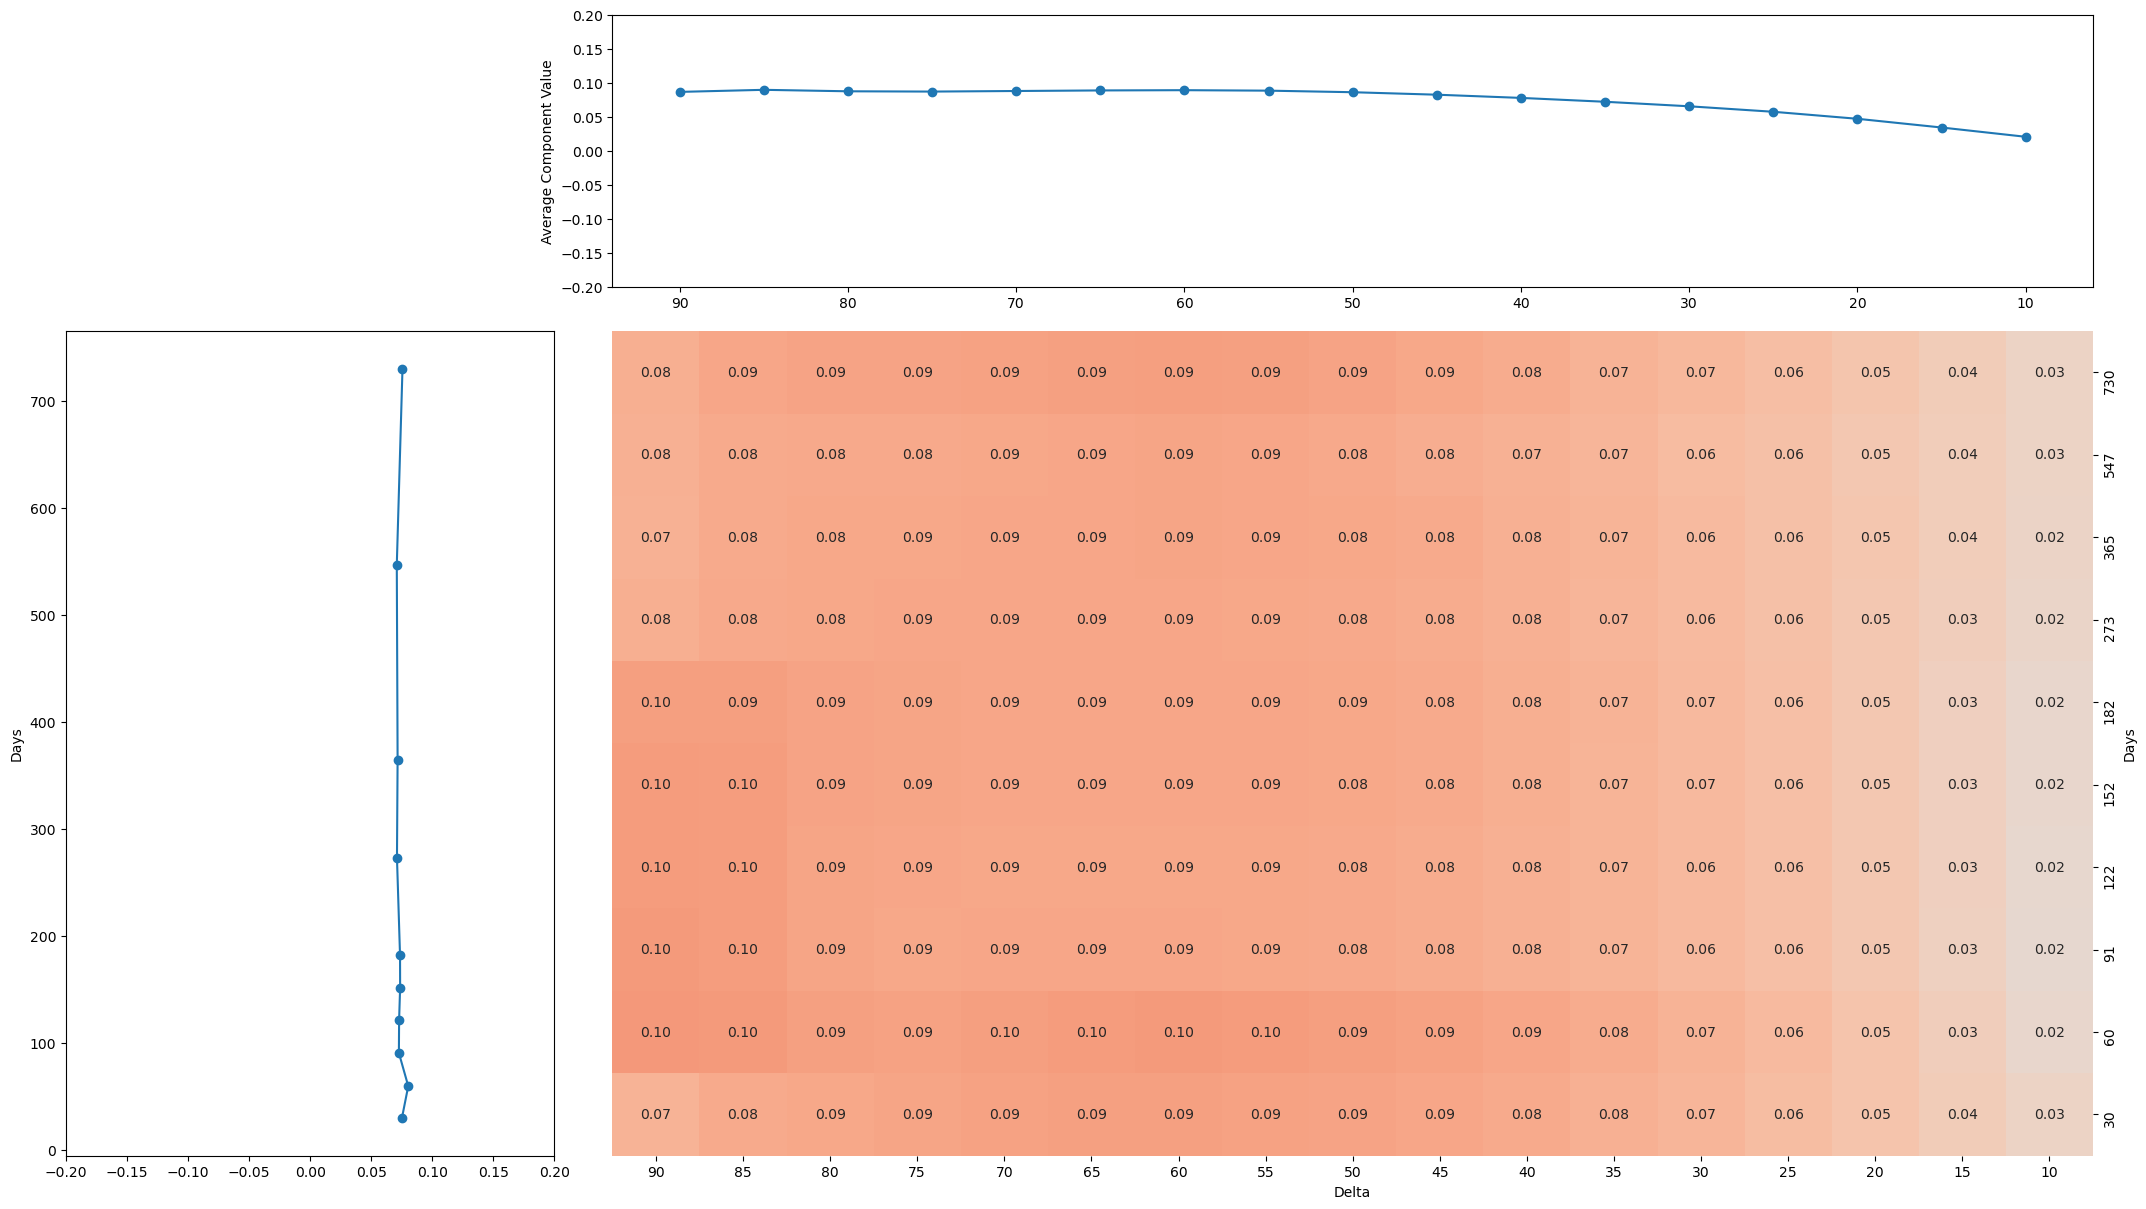

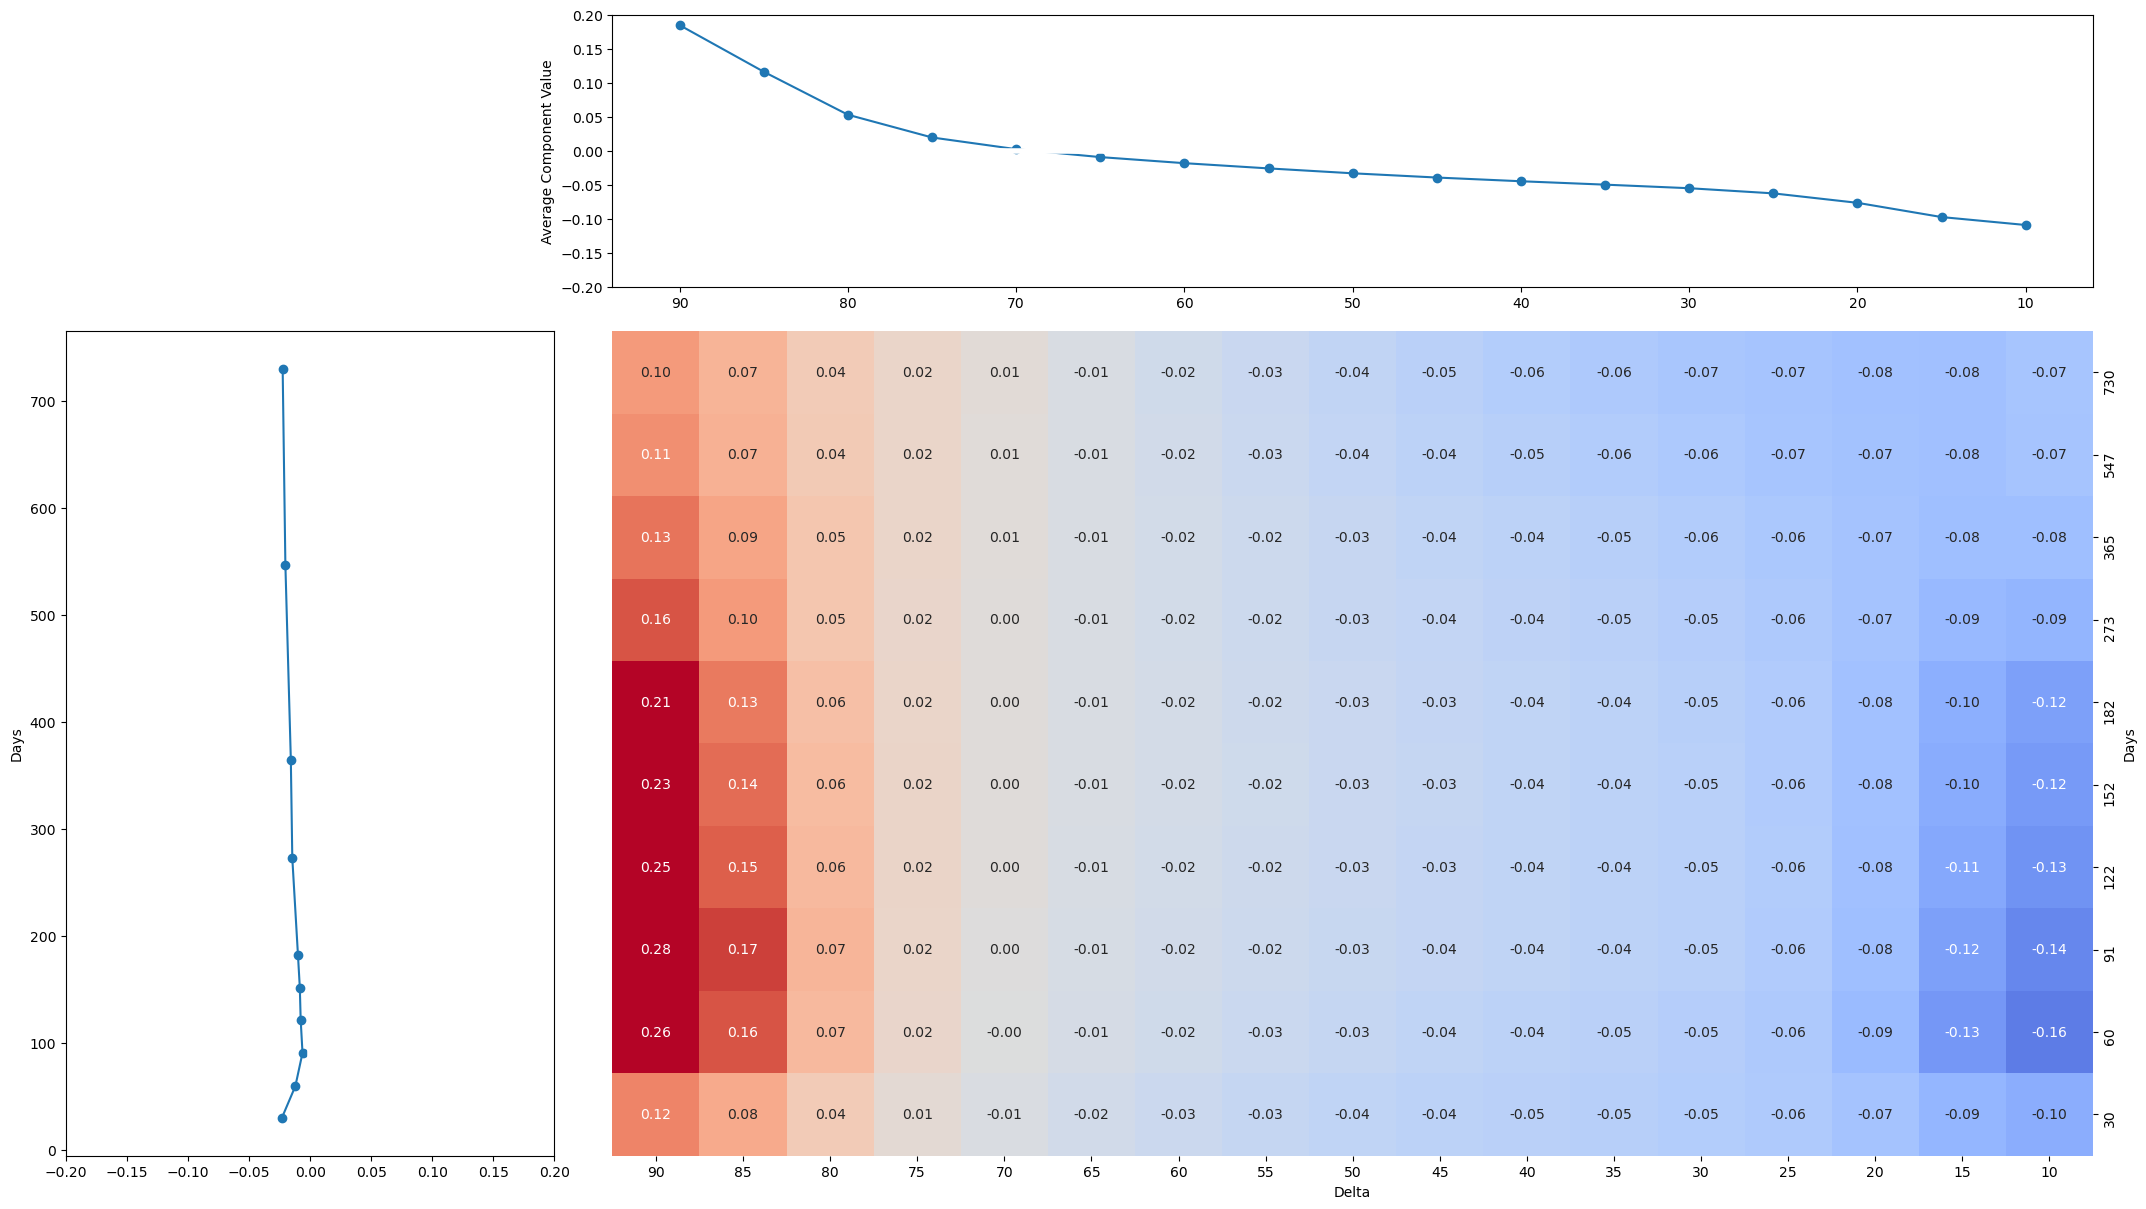

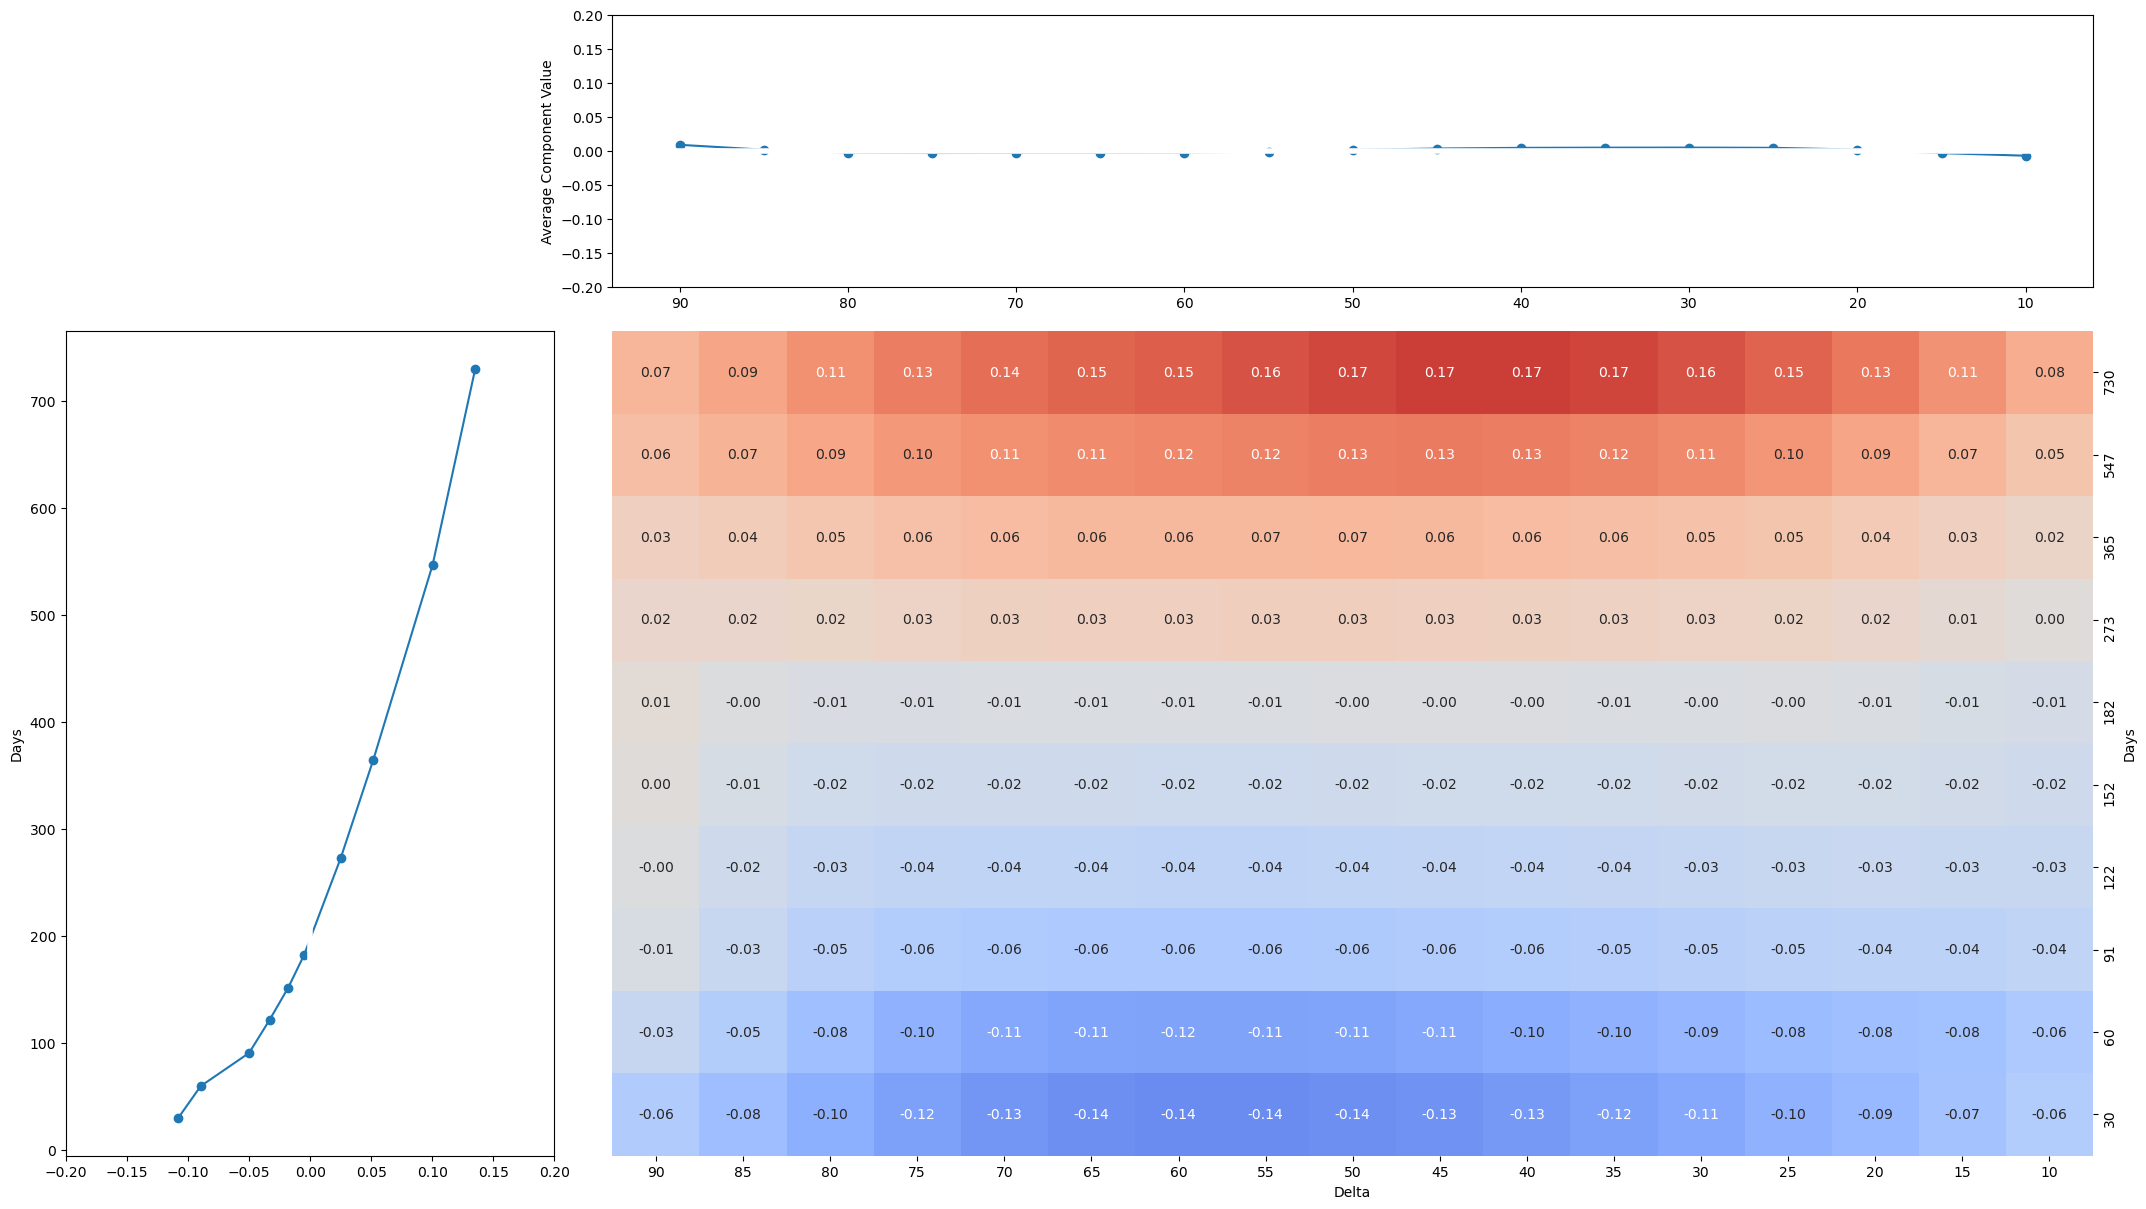

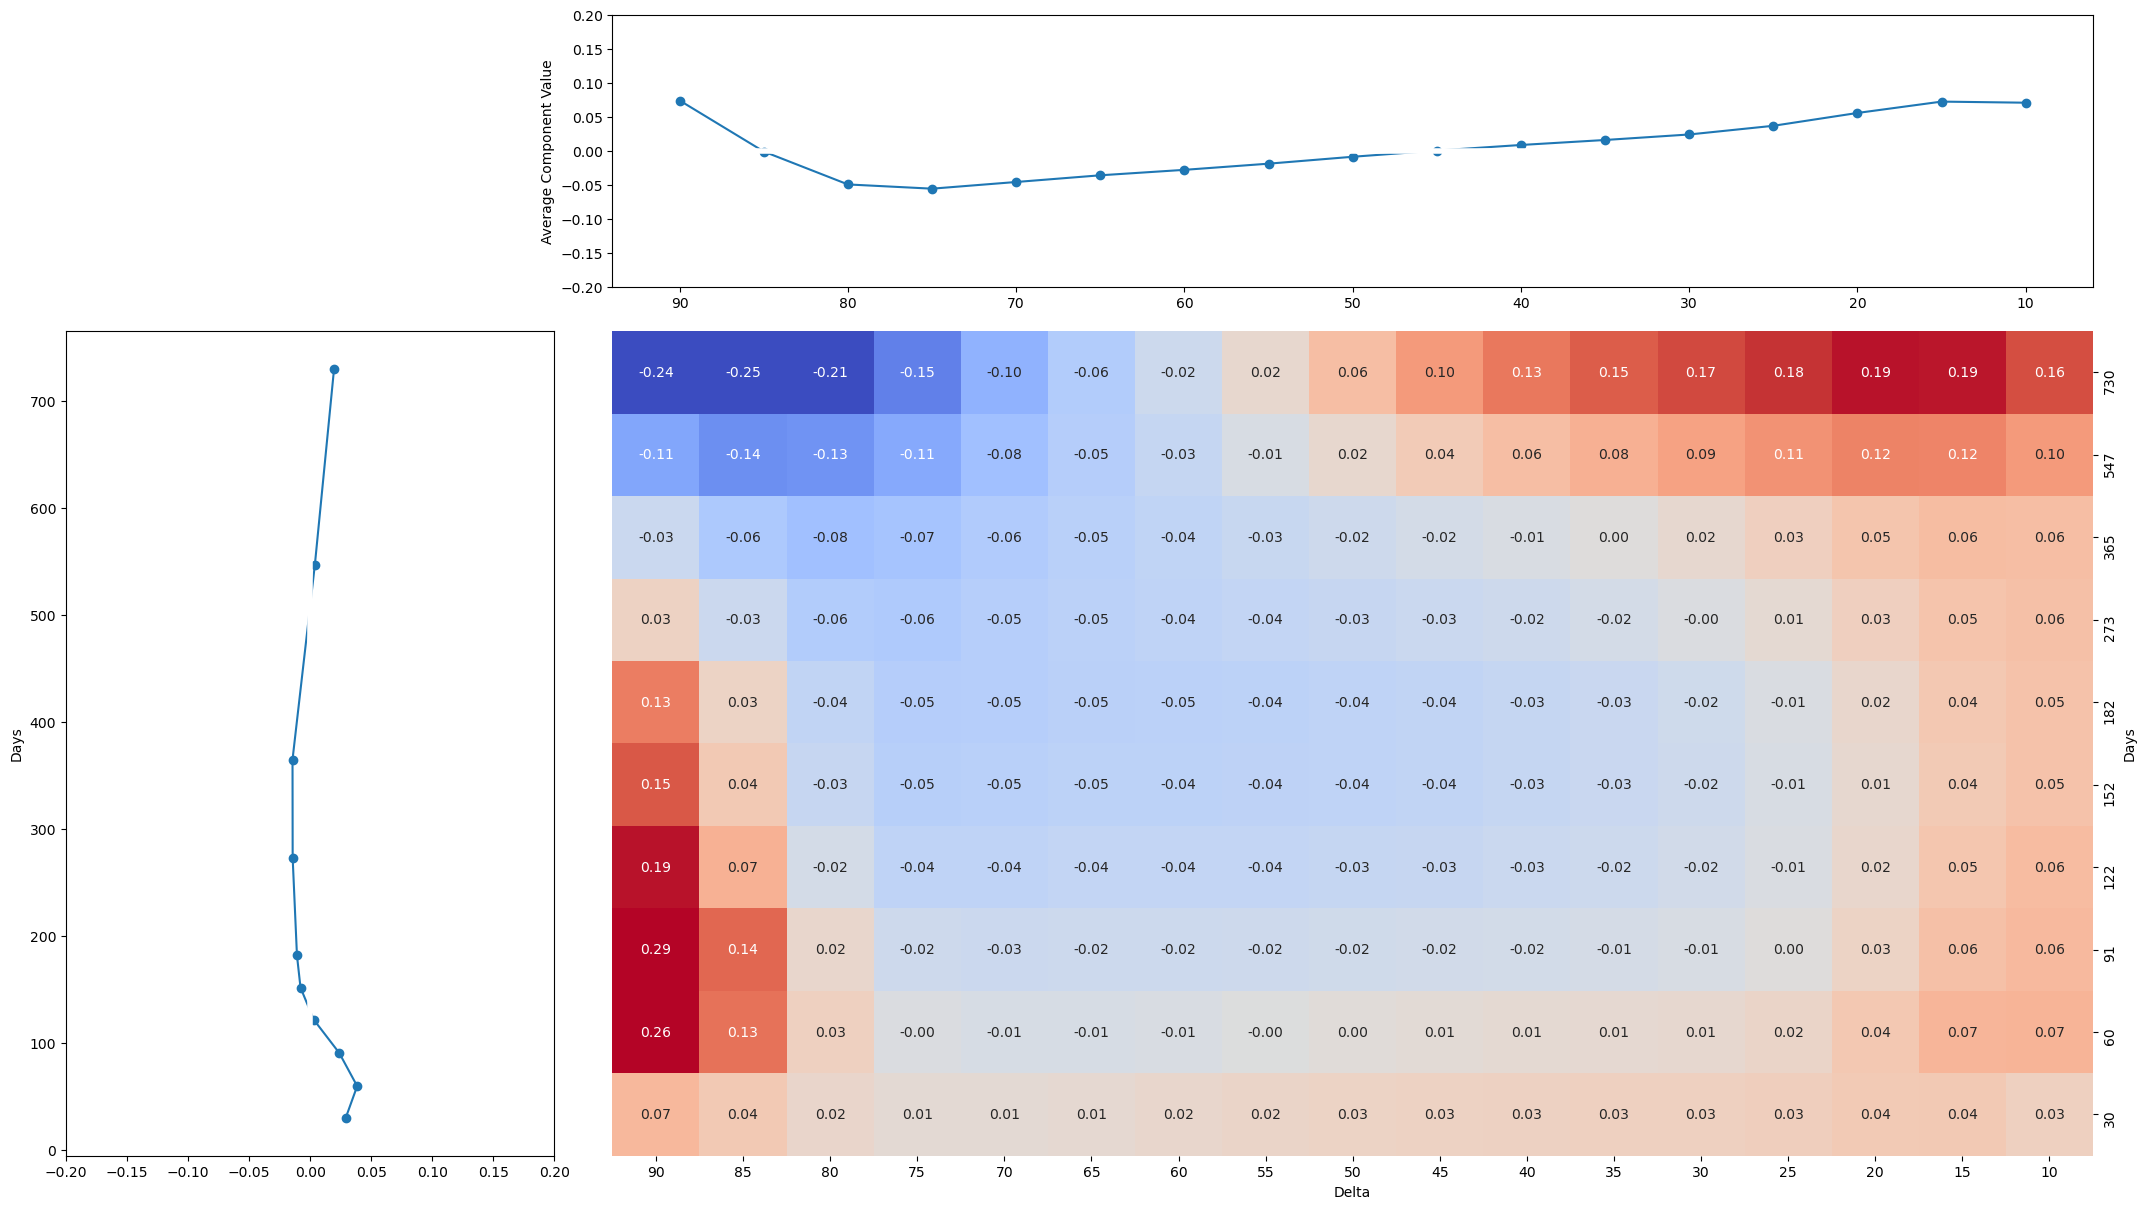

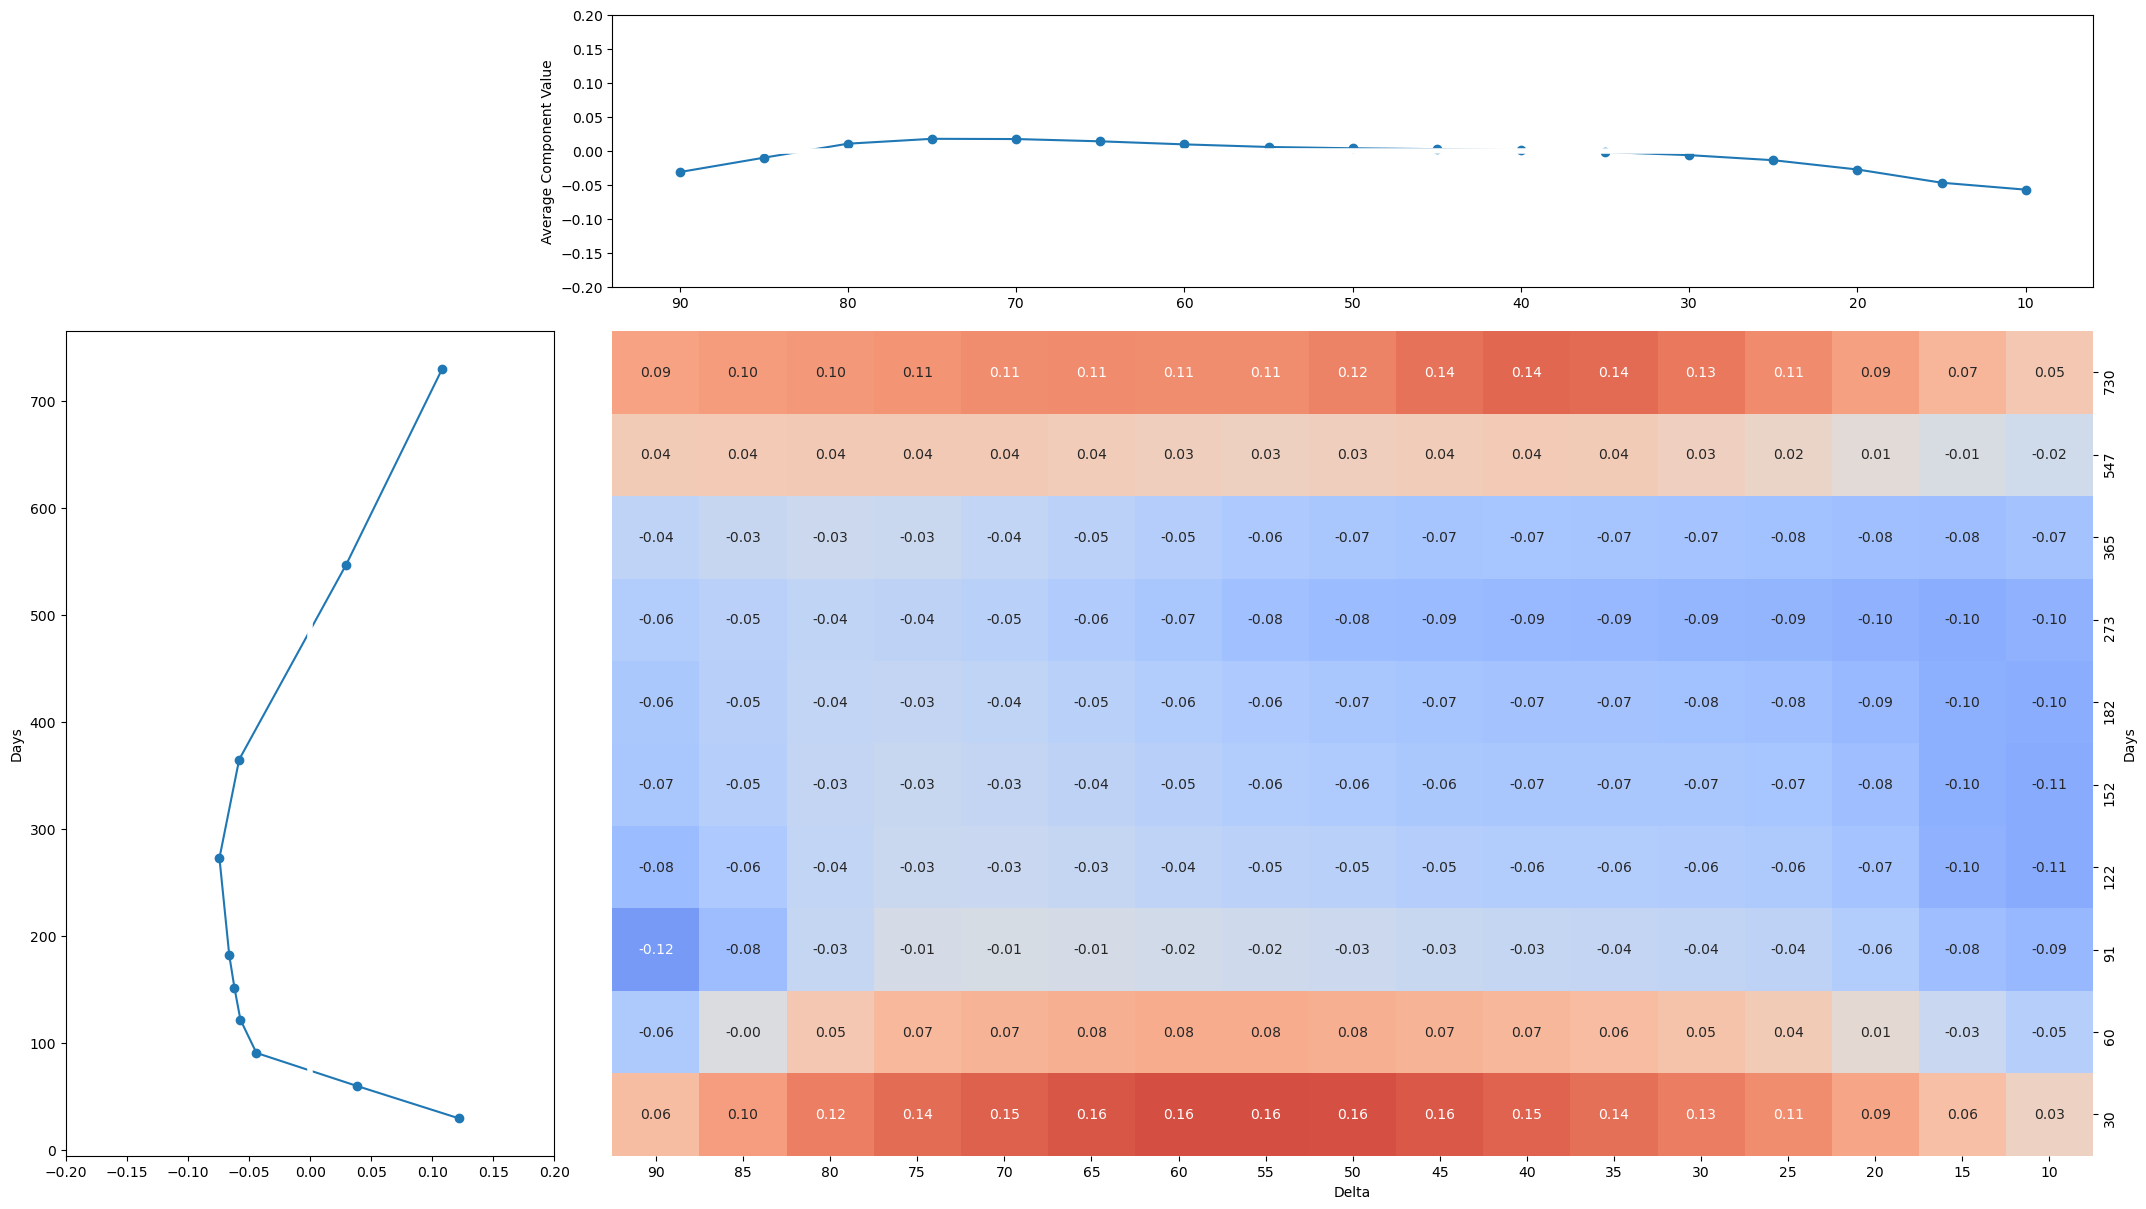

In [74]:
def plot_component(component, title, scale=None, save=None):
  component_stacked = pd.DataFrame(component, index=aapl_iv_grouped.columns).stack()
  heatmap_data = component_stacked.unstack(level=1)
  heatmap_data.index = heatmap_data.index.droplevel(1)
  
  fig, axes = plt.subplots(2, 2, figsize=(21, 12), gridspec_kw={'width_ratios': [0.33, 1], 'height_ratios': [0.33, 1]})
  plt.tight_layout()
  sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", vmin=scale[0] if scale else None, vmax=scale[1] if scale else None, ax=axes[1][1], cbar=False)
  axes[1][1].set_xlabel('Delta')
  axes[1][1].set_ylabel('Days')
  axes[1][1].invert_yaxis()  # Reverse the y-axis direction
  axes[1][1].invert_xaxis()  # Reverse the x-axis direction
  axes[1][1].yaxis.set_label_position("right")
  axes[1][1].yaxis.tick_right()
  
  avg_component_delta = component_stacked.groupby(level=1).mean()
  axes[0][1].plot(avg_component_delta.index, avg_component_delta.values, marker='o')
  # axes[0][1].set_title(f'Average {title} across Delta')
  axes[0][1].set_xlabel(' ')
  axes[0][1].set_ylabel('Average Component Value')
  axes[0][1].set_ylim(scale)  # Apply the scale to the y-axis
  axes[0][1].axhline(0, color='white', linewidth=4)  # Add a thick white line at y=0
  axes[0][1].invert_xaxis()  # Reverse the x-axis direction
  
  avg_component_days = component_stacked.groupby(level=0).mean()
  axes[1][0].plot(avg_component_days.values, avg_component_days.index, marker='o')
  # axes[1][0].set_title(f'Average {title} across Days')
  axes[1][0].set_ylabel('Days')
  axes[1][0].set_xlabel(' ')
  axes[1][0].set_xlim(scale)  # Apply the scale to the x-axis
  axes[1][0].axvline(0, color='white', linewidth=4)  # Add a thick white line at x=0
  
  # Remove the empty bottom right plot
  fig.delaxes(axes[0][0])
  if save:
    plt.savefig(save, format='png')
  plt.show()

scale = (-.2, .2)
for i in range(5):
  plot_component(pca.components_[i], f'Principal Component {i}, {pca.explained_variance_ratio_[i]:0.1%} explained variance', scale, save=f'./pics/pc{i+1}.png')


# Estimating Precision Matrices in Ill-Conditioned Scenarios

## Introduction

The **precision matrix** $ \Theta = \Sigma^{-1} $ (inverse covariance matrix) is critical in many statistical and machine learning applications, such as graphical models and shrinkage-based estimators. However, directly computing $ \Sigma^{-1} $ can be **numerically unstable** when $ \Sigma $ is **ill-conditioned** or **singular** due to multicollinearity, high-dimensionality ($ p > n $), or near-dependencies among variables.

Below are several alternative methods to estimate the precision matrix robustly:

## Regularized (Shrinkage) Estimators

These approaches add a penalty to stabilize the covariance matrix before inversion.

### 1. Ridge Regularization (Ledoit-Wolf Shrinkage)

- **Estimator:**
  $$
  \hat{\Sigma}_\lambda = (1 - \lambda) \hat{\Sigma} + \lambda I
  $$
  where $ \lambda $ is the shrinkage parameter.
- **Advantage:** Ensures invertibility and reduces estimation error.
- **Disadvantage:** Assumes all variables shrink equally.

### 2. Graphical Lasso (GLasso)

- Estimates $ \Theta $ directly by solving:
  $$
  \hat{\Theta} = \arg\min_{\Theta \succ 0} \left\{ \text{tr}(\hat{\Sigma} \Theta) - \log|\Theta| + \lambda \|\Theta\|_1 \right\}
  $$
- **Advantage:** Encourages sparsity, interpretable results.
- **Disadvantage:** Tuning $ \lambda $ is nontrivial.

## Bayesian Methods

Instead of estimating $ \Theta $ directly, Bayesian methods impose prior distributions.

### 1. Bayesian Wishart Prior

- Uses an **inverse-Wishart prior** $ W^{-1}(\Psi, \nu) $ on $ \Sigma $ to ensure a well-conditioned estimate.
- **Advantage:** Avoids singular estimates, robust for small samples.
- **Disadvantage:** Computationally intensive.

$$\Theta \mid X \sim W(\Psi + S, \nu + n)$$

### 2. Bayesian Graphical Models

- Places sparsity-inducing priors on $ \Theta $, such as **G-Wishart priors**.
- **Advantage:** Adaptively selects nonzero elements in $ \Theta $.
- **Disadvantage:** Requires MCMC methods for inference.

## Factor Models and Low-Rank Approximations

These methods approximate $ \Sigma $ using latent factors, reducing dimensionality.

### 1. Factor Analysis

- Models covariance as:
  $$
  \Sigma = LL^\top + D
  $$
  where $ L $ is a low-rank factor matrix and $ D $ is a diagonal matrix.
- **Advantage:** Mitigates multicollinearity effects.
- **Disadvantage:** Requires tuning the rank of $ L $.

### 2. Thresholded Covariance Estimation

- Sets small eigenvalues to a threshold before inversion.
- **Advantage:** Controls conditioning.
- **Disadvantage:** Requires choosing the threshold carefully.

## Robust and Nonparametric Methods

These approaches use robust statistics to avoid instability.

### 1. Minimum Covariance Determinant (MCD)

- Uses only a subset of data points to estimate $ \Sigma $.
- **Advantage:** Resistant to outliers.
- **Disadvantage:** Computationally expensive.

### 2. Kernel Density Estimators (KDE)

- Nonparametric smoothing of the empirical covariance.
- **Advantage:** No distributional assumptions.
- **Disadvantage:** Requires bandwidth selection.

## Conclusion

For **high-dimensional settings** ($ p > n $), **Graphical Lasso** and **Bayesian methods** offer stable solutions. For **small-sample or ill-conditioned problems**, **Ledoit-Wolf shrinkage** or **factor-based models** are preferable. Robust methods are useful when data contains **outliers**.


simple portfolio vega risk -1.5328470711352815


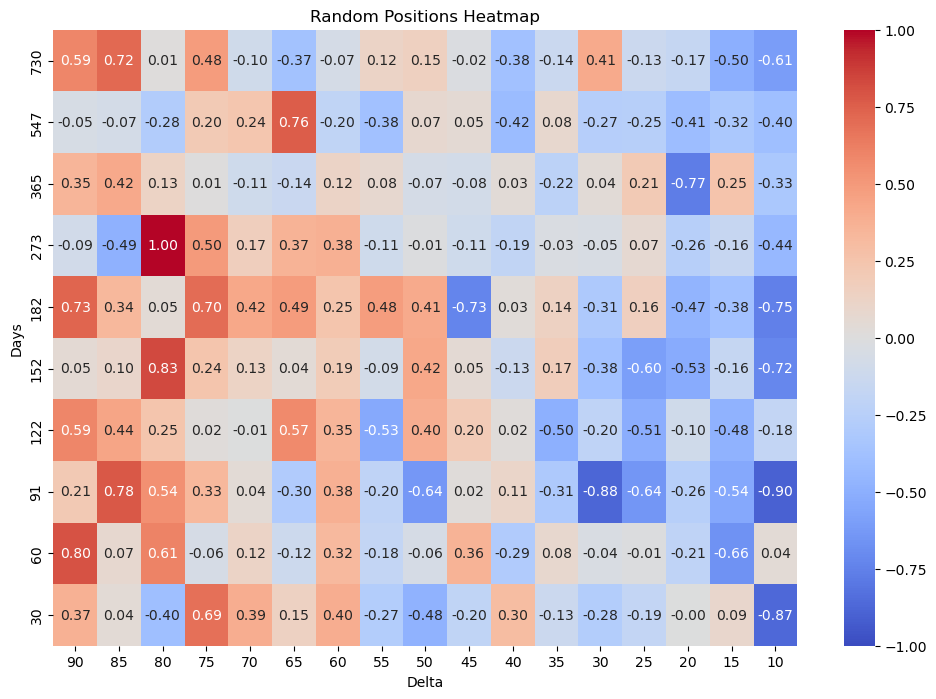

In [89]:
random_positions = (np.random.normal(loc=0, scale=1, size=170)+np.array([np.linspace(-1,1,17)] * 10).reshape(-1))
random_positions /= random_positions.max()
mapped_positions = pd.Series(random_positions, index=cov_df.columns)


print(f'simple portfolio vega risk {mapped_positions.sum()}')
plot_heatmap(mapped_positions, 'Random Positions Heatmap')

In [91]:
stratified_position.abs().mean()

np.float64(0.6)

simple portfolio vega risk 0.0


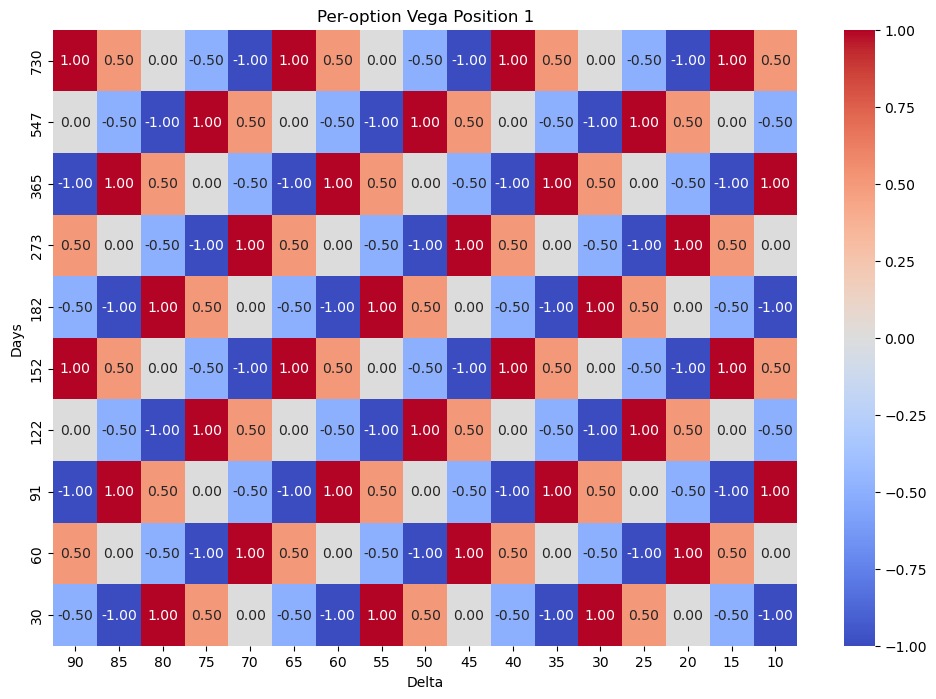

In [93]:
stratified_position = np.array([np.linspace(-1,1,5)] * 34).reshape(-1)
# random_positions /= random_positions.max()
stratified_position = pd.Series(stratified_position, index=cov_df.columns)
print(f'simple portfolio vega risk {stratified_position.sum()}')
plot_heatmap(stratified_position, 'Per-option Vega Position 1')


simple portfolio vega risk 0.0


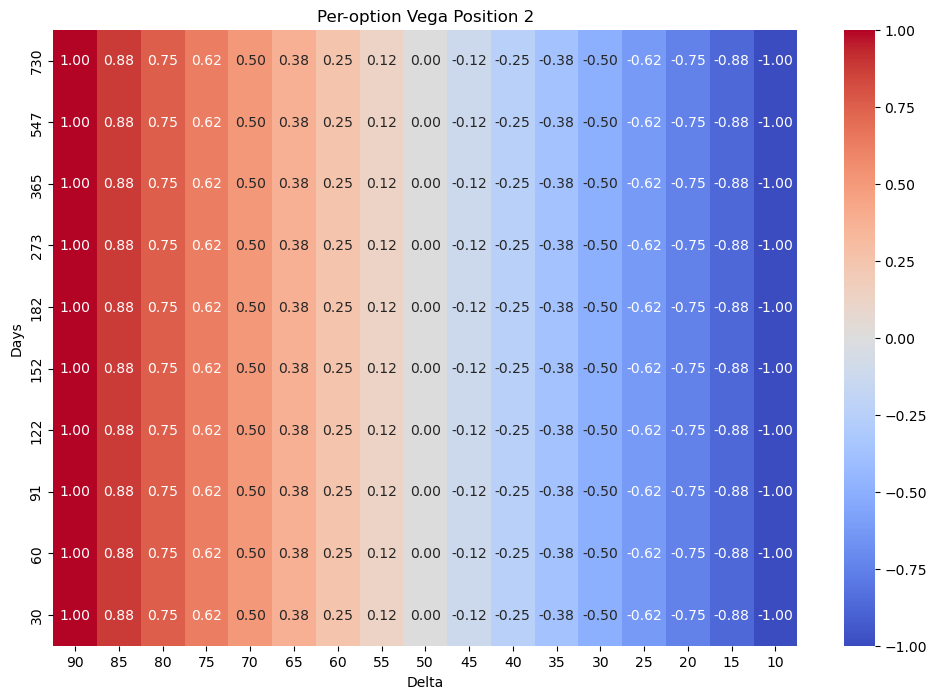

In [95]:
block_position = np.array([np.linspace(-1,1,17)] * 10).reshape(-1)
# random_positions /= random_positions.max()
block_position = pd.Series(block_position, index=cov_df.columns)
print(f'simple portfolio vega risk {block_position.sum()}')
plot_heatmap(block_position, 'Per-option Vega Position 2')


Covariance IV risk 0.0531319751349749


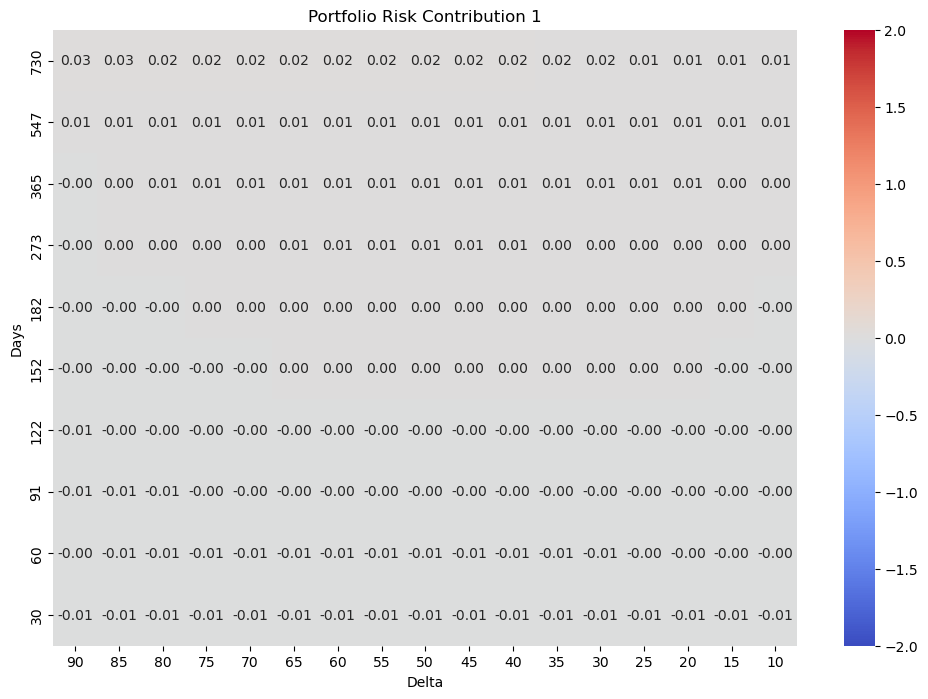

In [97]:
print(f'Covariance IV risk {stratified_position@cov_matrix@stratified_position}')
plot_heatmap(pd.Series(stratified_position@cov_matrix, index=cov_df.columns), "Portfolio Risk Contribution 1",scale=(-2,2))

Covariance IV risk 69.50092247622248


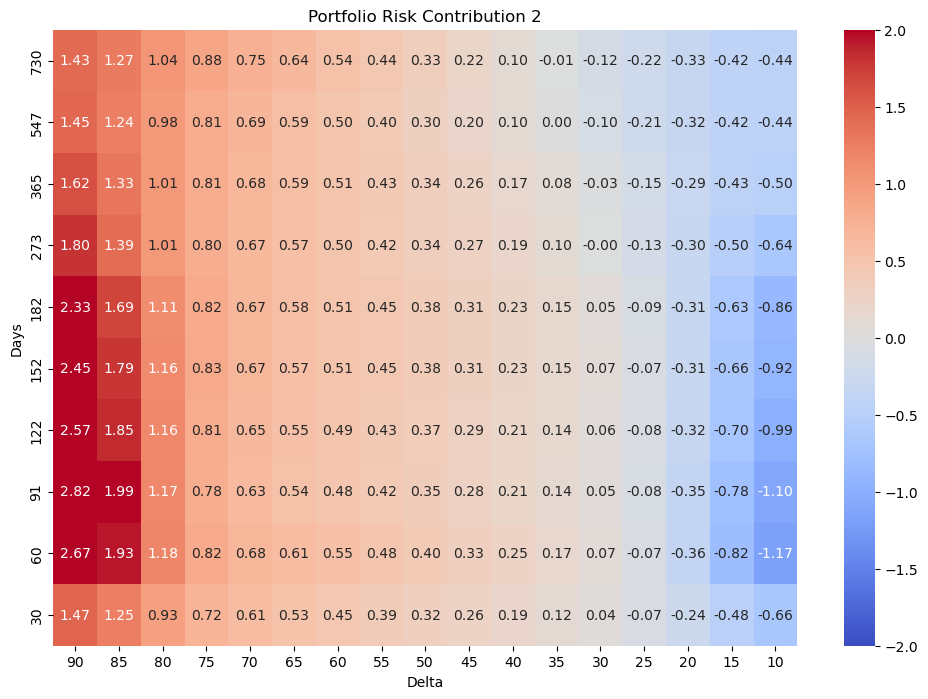

In [99]:
print(f'Covariance IV risk {block_position@cov_matrix@block_position}')
plot_heatmap(pd.Series(block_position@cov_matrix, index=cov_df.columns), "Portfolio Risk Contribution 2", scale=(-2,2))

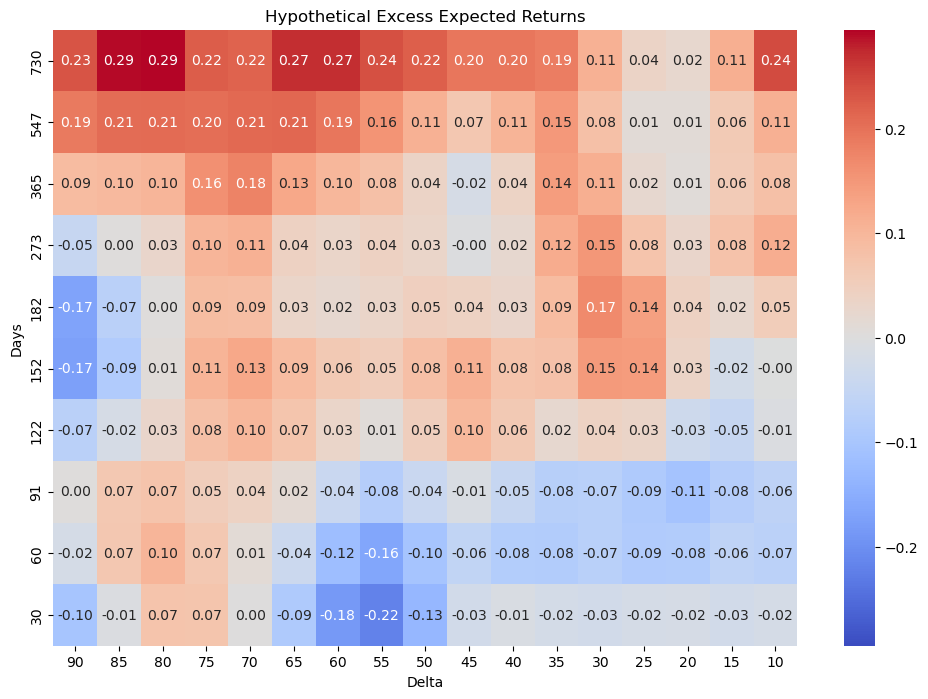

In [101]:
idx = pd.IndexSlice

random_evs = np.random.normal(loc=0, scale=.2, size=170)
mapped_alphas = pd.Series(random_evs, index=cov_df.columns)
mapped_alphas.loc[idx[30:60, 10:30]] += .15
mapped_alphas.loc[idx[30:91, 65:85]] += .2

# Add a .2 increase in the fronts and linear interpolate to the back to -.2
front_increase = -0.15
back_decrease = +0.2
num_points = len(mapped_alphas)
interpolated_values = np.linspace(front_increase, back_decrease, num_points)
mapped_alphas += interpolated_values


mapped_alphas_grid = mapped_alphas.unstack()

# Smooth the grid with a specified sigma value
sigma_value = 1  # Adjust this value to control the level of smoothing
mapped_alphas = smooth_grid(mapped_alphas_grid, sigma=sigma_value)

# Display the smoothed grid
mapped_alphas

plot_heatmap(mapped_alphas, "Hypothetical Excess Expected Returns")


In [103]:
K = 10
U,S,VT = np.linalg.svd(cov_matrix)
ridge_inversion_eps = 1e-4
U_k, S_k, VT_k = U[:,:K], S[:K], VT[:K, :]
reduced_rank_cov = U_k @ np.diag(S_k) @ VT_k
reduced_rank_cov_inv = U_k @ np.diag(1 / (S_k+ridge_inversion_eps)) @ VT_k[:K, :]

full-rank covariance IV risk 10.050369200777142
full-rank covariance IV risk 10.027961690063979


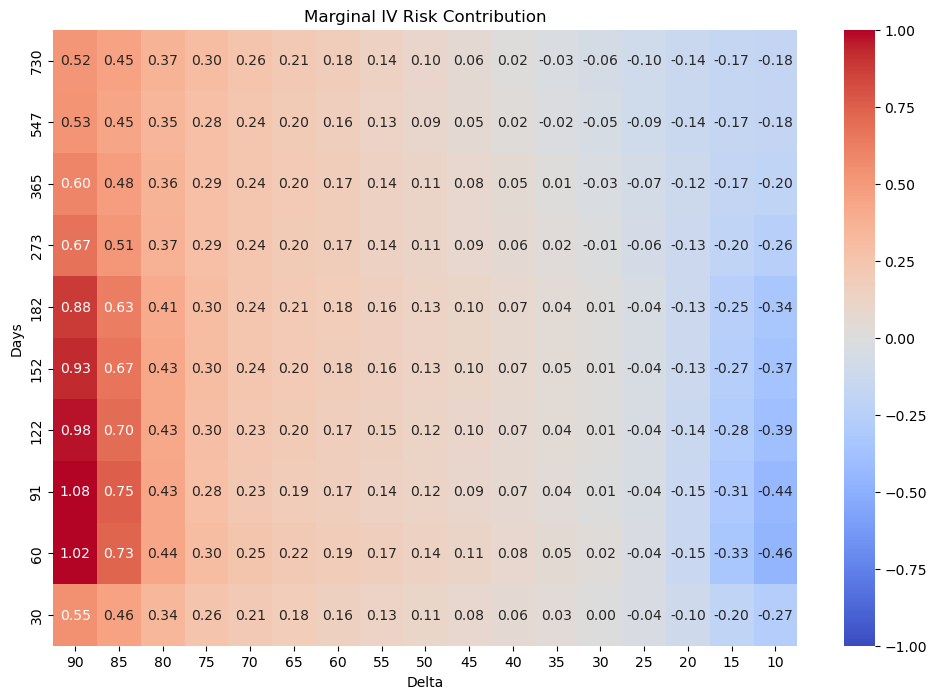

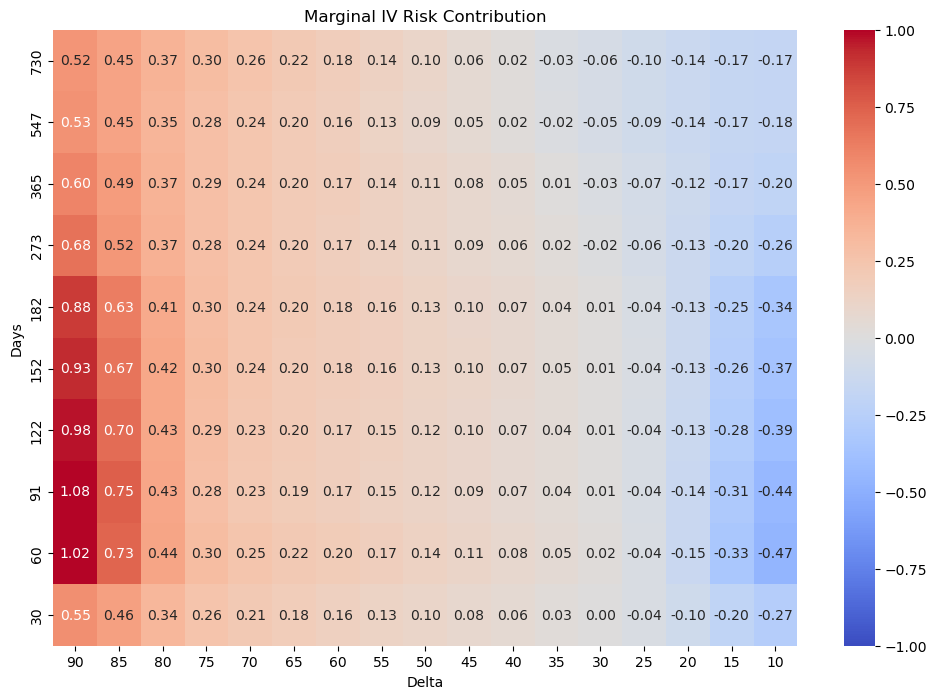

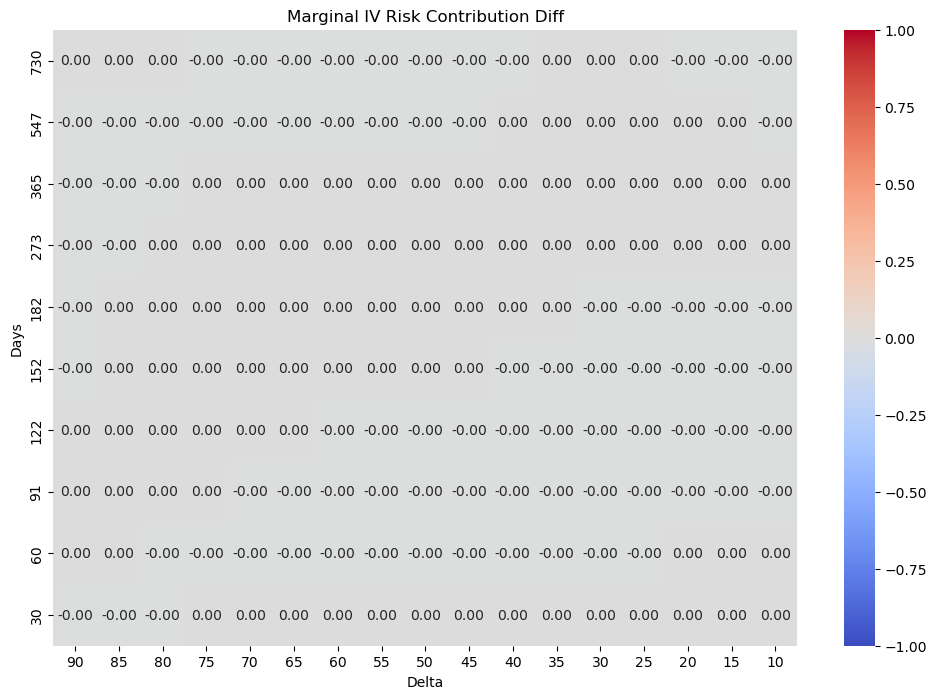

In [104]:
print(f'full-rank covariance IV risk {mapped_positions@cov_matrix@mapped_positions}')
print(f'full-rank covariance IV risk {mapped_positions@reduced_rank_cov@mapped_positions}')
plot_heatmap(pd.Series(mapped_positions@cov_matrix, index=cov_df.columns), "Marginal IV Risk Contribution", scale=(-1,1))
plot_heatmap(pd.Series(mapped_positions@reduced_rank_cov, index=cov_df.columns), "Marginal IV Risk Contribution", scale=(-1,1))
plot_heatmap(pd.Series(mapped_positions@cov_matrix, index=cov_df.columns) - pd.Series(mapped_positions@reduced_rank_cov, index=cov_df.columns), "Marginal IV Risk Contribution Diff", scale=(-1,1))

In [106]:
aapl_iv_flattened

days              30                                                    \
delta             10        15        20        25        30        35   
(date, )                                                                 
2015-01-05  0.076798  0.110219  0.142193  0.171552  0.197383  0.220115   
2015-01-06  0.002574  0.014849  0.040318  0.063628  0.074489  0.076237   
2015-01-07 -0.023506 -0.037203 -0.057785 -0.075806 -0.084996 -0.087266   
2015-01-08 -0.017044 -0.022850 -0.022340 -0.022126 -0.025048 -0.029547   
2015-01-09  0.018050  0.035700  0.044698  0.048233  0.053323  0.061745   
...              ...       ...       ...       ...       ...       ...   
2017-12-22 -0.019871  0.021120  0.027749  0.027841  0.025231  0.019696   
2017-12-26  0.436754  0.517678  0.503938  0.497292  0.520674  0.552950   
2017-12-27 -0.071444 -0.065894 -0.036040 -0.009639  0.001821  0.007123   
2017-12-28 -0.007676  0.015536  0.021458  0.011547  0.001779 -0.008684   
2017-12-29 -0.366189 -0.238569 -0.074390  0.012058  0.039268  0.058774   

days                                                ...       730            \
delta             40        45        50        55  ...        45        50   
(date, )                                            ...                       
2015-01-05  0.239375  0.254226  0.264158  0.270934  ... -0.066318 -0.014735   
2015-01-06  0.074180  0.070690  0.067024  0.062834  ...  0.456658  0.479406   
2015-01-07 -0.087620 -0.088237 -0.086259 -0.081223  ...  0.338389  0.305055   
2015-01-08 -0.032573 -0.032538 -0.032723 -0.035130  ...  0.380911  0.375688   
2015-01-09  0.069797  0.075057  0.078513  0.082253  ...  0.078049  0.113754   
...              ...       ...       ...       ...  ...       ...       ...   
2017-12-22  0.012275  0.000298 -0.011665 -0.012925  ...  0.136363  0.107393   
2017-12-26  0.573680  0.587179  0.601385  0.589741  ... -0.724982 -0.731855   
2017-12-27  0.010794  0.020176  0.034207  0.047381  ...  0.106872  0.048417   
2017-12-28 -0.020873 -0.033720 -0.039997 -0.043781  ... -0.001095  0.010121   
2017-12-29  0.094942  0.127727  0.149288  0.172249  ... -0.638956 -0.543511   

days                                                                    \
delta             55        60        65        70        75        80   
(date, )                                                                 
2015-01-05 -0.007059 -0.054284 -0.110850 -0.125604 -0.088457 -0.018920   
2015-01-06  0.498426  0.530752  0.561401  0.564232  0.529535  0.466790   
2015-01-07  0.278965  0.269290  0.266541  0.260925  0.255105  0.238702   
2015-01-08  0.361247  0.358326  0.380282  0.394270  0.370799  0.314795   
2015-01-09  0.150389  0.184066  0.205374  0.205078  0.183970  0.155717   
...              ...       ...       ...       ...       ...       ...   
2017-12-22  0.066703  0.030339 -0.021826 -0.104850 -0.187236 -0.213376   
2017-12-26 -0.667872 -0.586836 -0.521135 -0.463330 -0.420448 -0.414218   
2017-12-27 -0.044879 -0.079919 -0.036988 -0.000153 -0.026627 -0.071996   
2017-12-28 -0.018762 -0.095756 -0.170695 -0.194142 -0.156948 -0.097985   
2017-12-29 -0.422613 -0.322240 -0.227583 -0.110394  0.009108  0.140969   

days                            
delta             85        90  
(date, )                        
2015-01-05  0.038334  0.051192  
2015-01-06  0.390208  0.292228  
2015-01-07  0.187234  0.105602  
2015-01-08  0.264146  0.235462  
2015-01-09  0.141947  0.140850  
...              ...       ...  
2017-12-22 -0.158388 -0.056586  
2017-12-26 -0.435682 -0.436585  
2017-12-27 -0.089227 -0.101779  
2017-12-28 -0.072667 -0.087255  
2017-12-29  0.348899  0.574301  

[754 rows x 170 columns]

In [108]:

def smooth_grid(data, sigma=1):
  """
  Smooths a grid of values using a Gaussian filter.

  Parameters:
    data (pd.DataFrame): The grid of values to smooth.
    sigma (float): The standard deviation for Gaussian kernel. Higher values result in more smoothing.

  Returns:
    pd.DataFrame: The smoothed grid of values.
  """
  smoothed_data = scipy.ndimage.gaussian_filter(data, sigma=sigma)
  return pd.DataFrame(smoothed_data, index=data.index, columns=data.columns).stack()

# Unstack the mapped_alphas series to get a grid


### Mean-Variance Optimization: Optimal Portfolio Weights

Given the expected returns vector $\mu$ and the covariance matrix $\Sigma$, the optimal portfolio weights $w$ can be obtained by solving the following optimization problem:

\begin{aligned}
& \underset{w}{\text{maximize}}
& & \frac{w^T \mu}{\sqrt{w^T \Sigma w}} \\
& \text{subject to}
& & \sum\_{i=1}^{n} w_i = 1
\end{aligned}

$$w_K = \frac{\Sigma^{-1}_K \mu}{\mathbf{1}^T \Sigma^{-1}_K \mu}$$


In [110]:
# Compute the condition number
condition_number = singular_values[0] / singular_values[-1]

# Display the condition number
condition_number, singular_values[0], singular_values[-1]

NameError: name 'singular_values' is not defined

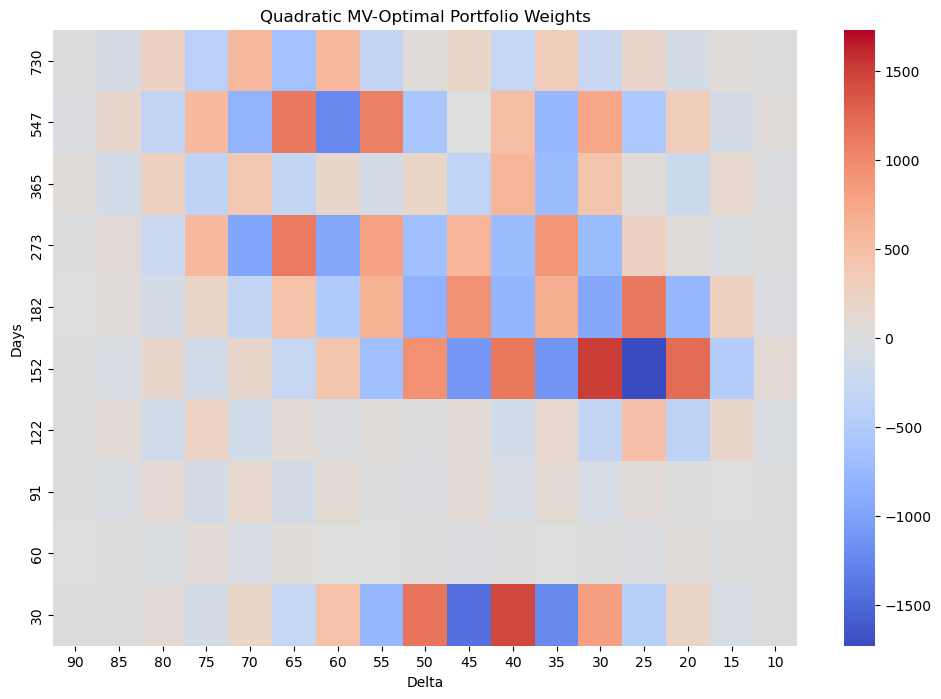

In [112]:
w = np.linalg.inv(cov_matrix)@mapped_alphas
w /= w.sum()
full_cov_opt_pf = pd.Series(w, index=cov_df.columns)
plot_heatmap(full_cov_opt_pf, "Quadratic MV-Optimal Portfolio Weights", show_values=False, save='./pics/unstable_position.png')

The condition number of a matrix $A$ is a measure of how sensitive the solution of a linear system is to changes in the input data. It is defined as the product of the norm of the matrix and the norm of its inverse. Mathematically, it is given by:

$$ \kappa(A) = \|A\| \cdot \|A^{-1}\| $$

For the 2-norm (spectral norm), the condition number can be computed using the singular values of the matrix $A$. If $\sigma_{\max}$ and $\sigma_{\min}$ are the largest and smallest singular values of $A$, respectively, then the condition number is:

$$ \kappa(A) = \frac{s*{\max}}{s*{\min}} = \frac{3.832}{8.75e-10} = 4.37e9 $$

where $s$ are the singular values of $A$.

In summary:

1. Compute the singular values of $A$.
2. Identify the largest singular value $\sigma_{\max}$.
3. Identify the smallest singular value $\sigma_{\min}$.
4. Calculate the condition number:

$$ \kappa(A) = \frac{\sigma*{\max}}{\sigma*{\min}} $$


### Principal Component Analysis (PCA) and Precision Matrix

Principal Component Analysis (PCA) is a technique used to reduce the dimensionality of a dataset while preserving as much variance as possible. The steps involved in PCA are as follows:

1. **Standardize the Data**: Center the data by subtracting the mean of each feature.
2. **Compute the Covariance Matrix**: Calculate the covariance matrix of the standardized data.
3. **Perform Eigen Decomposition**: Compute the eigenvalues and eigenvectors of the covariance matrix.
4. **Sort Eigenvalues and Eigenvectors**: Sort the eigenvalues in descending order and arrange the corresponding eigenvectors accordingly.
5. **Select Principal Components**: Choose the top $K$ eigenvectors that correspond to the largest eigenvalues to form the principal components.

Mathematically, let $X$ be the standardized data matrix with $n$ samples and $p$ features. The covariance matrix $\Sigma$ is given by:

$$
\Sigma = \frac{1}{n-1} X^T X
$$

Perform eigen decomposition:

$\Sigma = V \Lambda V^T$

Truncating after eigenvalue $k$:

$\Sigma_k = V_k \Lambda_k V_k^T$

Inverting:

$\Sigma_k^{-1} = V_k \Lambda_k^{-1} V_k^T$

Note that the precision matrix (inverse of the covariance matrix) is sensitive to the smallest eigenvalues. Truncating lower-valued principal components can significantly impact the precision matrix, as the reciprocals of small eigenvalues are large. This methodology doesn't distinguish between whether this is a loss of important precision information or covariance estimation error we're removing.

where $V_k$ contains the top $k$ eigenvectors and $\Lambda_k$ is the diagonal matrix of the top $k$ eigenvalues.

### Precision Matrix and Truncation

The precision matrix $\Sigma^{-1}$ is the inverse of the covariance matrix. If we truncate lower-valued principal components, the precision matrix of the truncated covariance matrix $\Sigma_k$ is given by:

However, truncating lower-valued principal components can significantly impact the precision matrix. The smallest eigenvalues, although contributing less to the variance, have a large influence on the precision matrix due to their reciprocals being large. Discarding these components can lead to a loss of important information and result in an inaccurate precision matrix.

### Impact on Precision Matrix

To highlight the impact, consider the eigenvalues $\lambda_1, \lambda_2, \ldots, \lambda_p$ sorted in descending order. The precision matrix is sensitive to the smallest eigenvalues:

$$
\Sigma^{-1} = V \Lambda^{-1} V^T
$$

If we truncate the smallest eigenvalues $\lambda_{k+1}, \ldots, \lambda_p$, the precision matrix becomes:

$$
\Sigma_k^{-1} = V_k \Lambda_k^{-1} V_k^T
$$

This truncation can lead to a significant loss of precision, especially if the discarded eigenvalues are small. Therefore, while PCA helps in dimensionality reduction, care must be taken when truncating components, as it can adversely affect the precision matrix and subsequent analyses.


In [113]:
K=1
U,S,VT = np.linalg.svd(cov_matrix)
ridge_inversion_eps = 1e-4
U_k, S_k, VT_k = U[:,:K], S[:K], VT[:K, :]
reduced_rank_cov = U_k @ np.diag(S_k) @ VT_k
reduced_rank_cov_inv = U_k @ np.diag(1 / (S_k+ridge_inversion_eps)) @ VT_k[:K, :]
single_factor_inv_cov = pd.DataFrame(reduced_rank_cov_inv, index=aapl_iv_flattened.columns, columns=aapl_iv_flattened.columns)*100


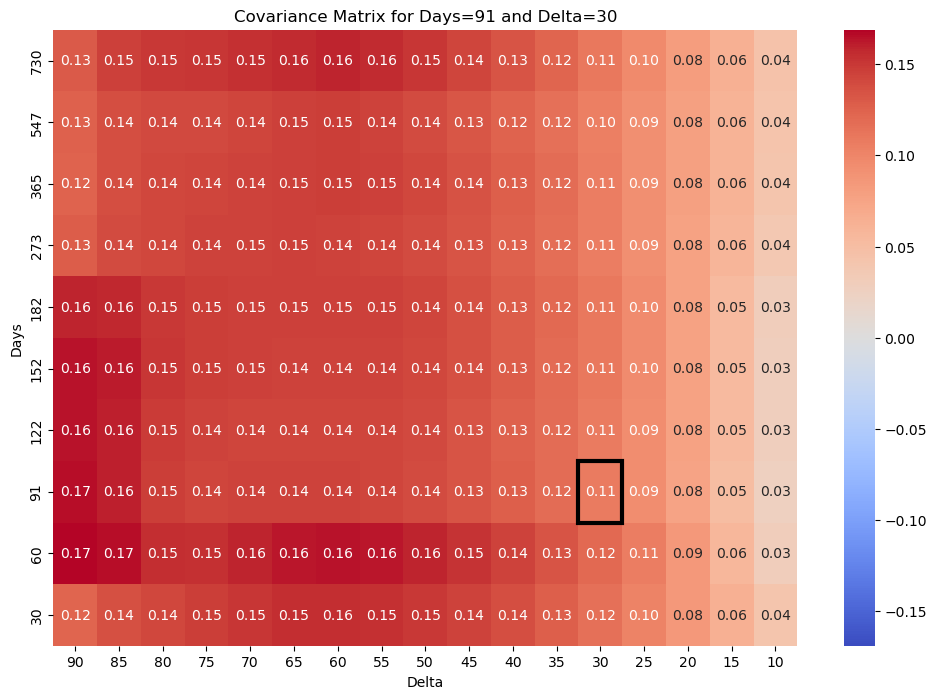

In [114]:
days_idx, delta_idx = 91,30
plot_single_option_covariance(single_factor_inv_cov, days_idx, delta_idx)

K=1 Sharpe=0.31308748092281036


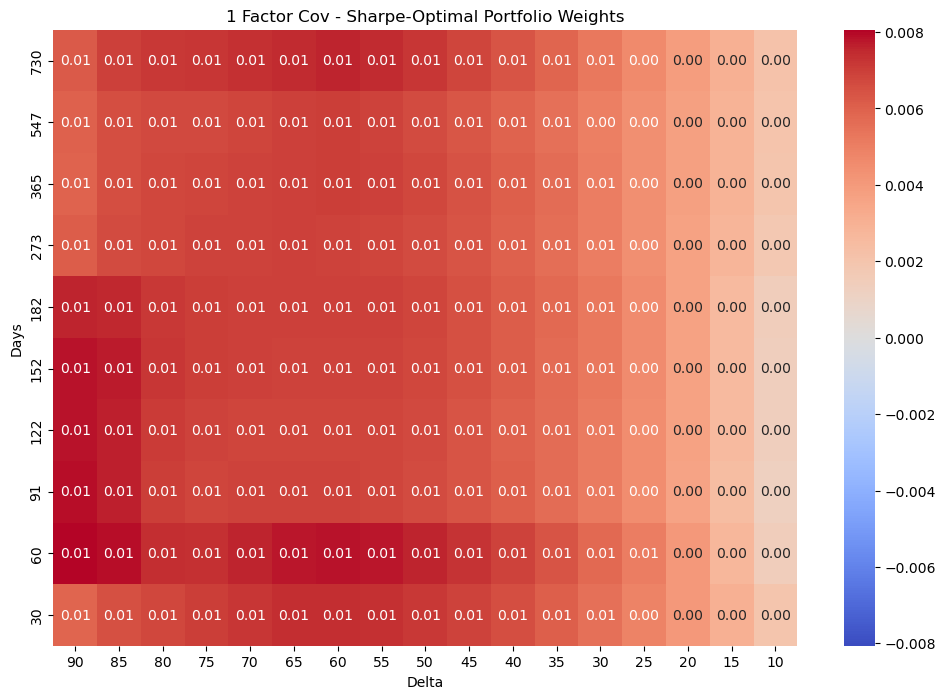

K=5 Sharpe=1.4554306793123253


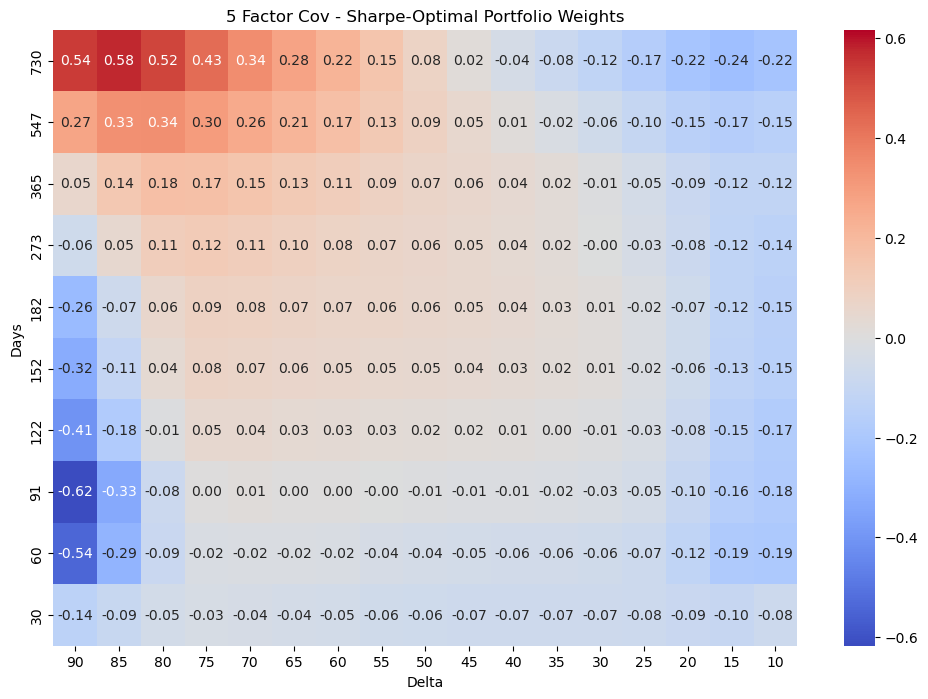

K=10 Sharpe=2.2238194642644538


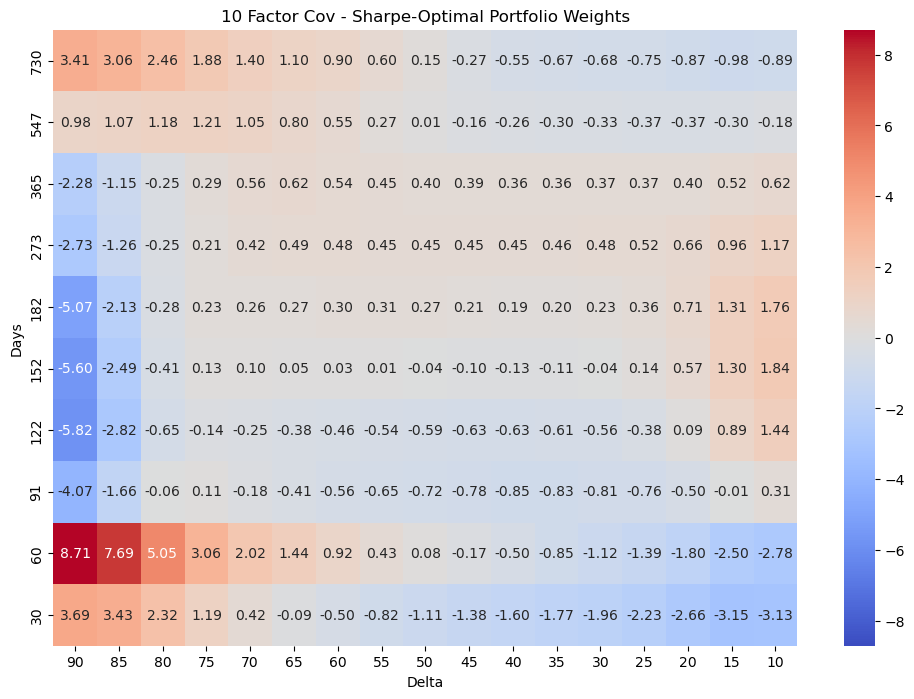

K=25 Sharpe=6.401147309755988


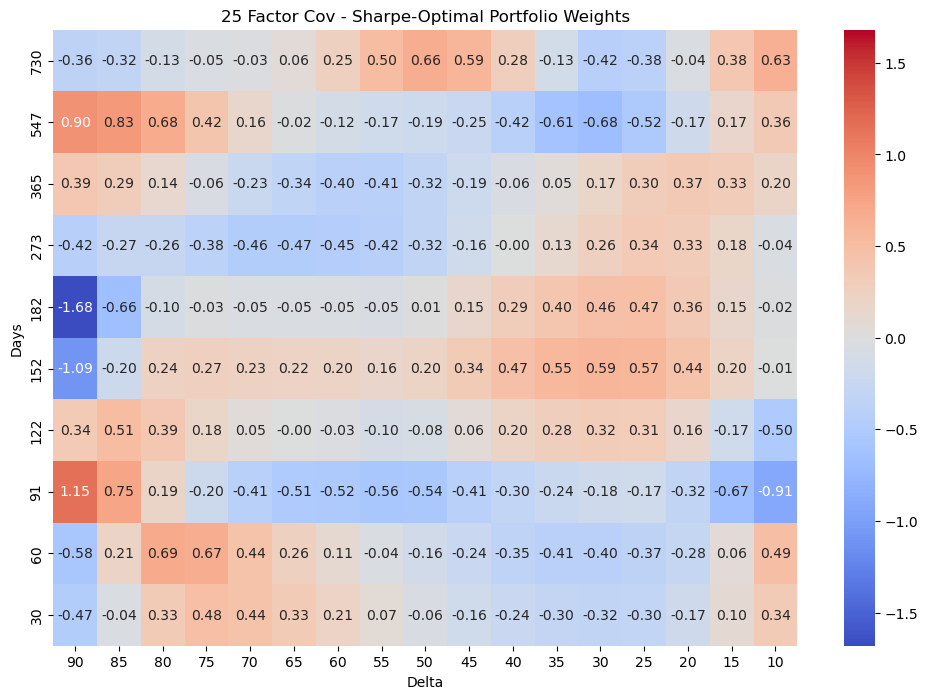

K=50 Sharpe=16.91769287584905


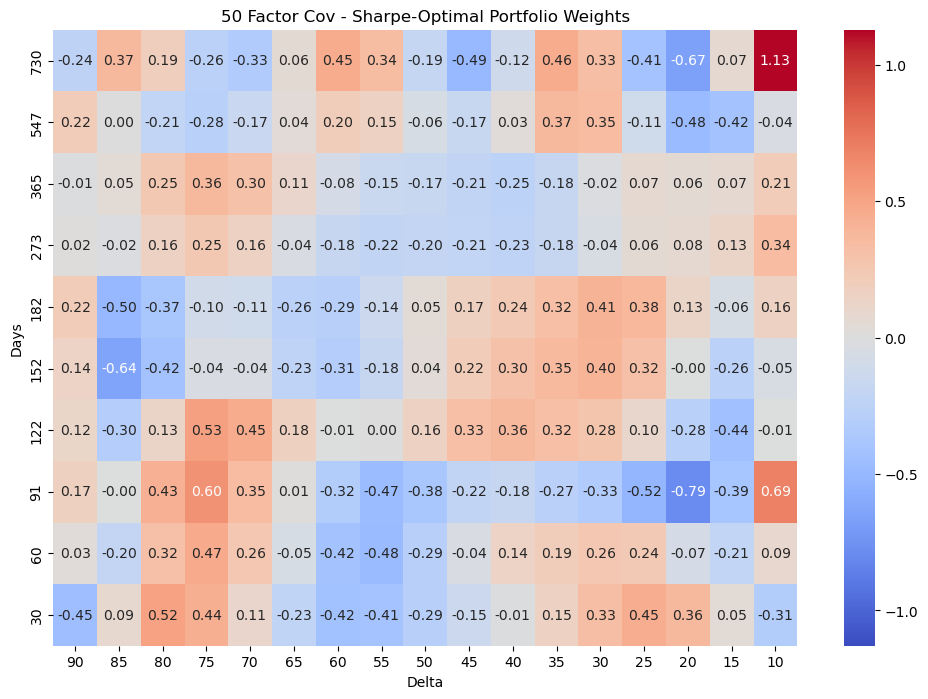

In [119]:
for K in [1,5,10,25,50]:
  U,S,VT = np.linalg.svd(cov_matrix)
  ridge_inversion_eps = 1e-4
  U_k, S_k, VT_k = U[:,:K], S[:K], VT[:K, :]
  reduced_rank_cov = U_k @ np.diag(S_k) @ VT_k
  reduced_rank_cov_inv = U_k @ np.diag(1 / (S_k+ridge_inversion_eps)) @ VT_k[:K, :]

  w = reduced_rank_cov_inv@mapped_alphas
  w /= w.sum() * np.sign(w.sum())
  reduced_cov_opt_pf = pd.Series(w, index=cov_df.columns)
  cov_aware_sharpe = (reduced_cov_opt_pf@mapped_alphas)/np.sqrt(reduced_cov_opt_pf@cov_matrix@reduced_cov_opt_pf)  
  print(f'K={K} Sharpe={cov_aware_sharpe}')
  plot_heatmap(reduced_cov_opt_pf, f"{K} Factor Cov - Sharpe-Optimal Portfolio Weights", save=f'./pics/cov_aware_pf_{K}.png')
  

In [116]:
alpha_weight_pf = pd.Series(mapped_alphas/(mapped_alphas.sum()*np.sign(mapped_alphas.sum())), index=cov_df.columns)

cov_aware_sharpe = (reduced_cov_opt_pf@mapped_alphas)/np.sqrt(reduced_cov_opt_pf@cov_matrix@reduced_cov_opt_pf)  
naive_alpha_pf_sharpe = (alpha_weight_pf@mapped_alphas)/np.sqrt(alpha_weight_pf@cov_matrix@alpha_weight_pf)
ill_conditioned_pf_sharpe = (full_cov_opt_pf@mapped_alphas)/np.sqrt(full_cov_opt_pf@cov_matrix@full_cov_opt_pf)
cov_aware_sharpe, naive_alpha_pf_sharpe, ill_conditioned_pf_sharpe

(np.float64(16.14694263971762),
 np.float64(1.3747548668876441),
 np.float64(-127.48428146825835))

In [117]:
display(reduced_cov_opt_pf@mapped_alphas,
        np.sqrt(reduced_cov_opt_pf@cov_matrix@reduced_cov_opt_pf),
        alpha_weight_pf@mapped_alphas,
        np.sqrt(alpha_weight_pf@cov_matrix@alpha_weight_pf)
) 

np.float64(1.8218429780398524)

np.float64(0.11282897441888189)

np.float64(0.25971547611597656)

np.float64(0.18891766261133924)

Side length: 170, PCA computation time: 0.02378702163696289 seconds
Side length: 340, PCA computation time: 0.0870668888092041 seconds
Side length: 510, PCA computation time: 0.19713687896728516 seconds
Side length: 680, PCA computation time: 0.3554513454437256 seconds
Side length: 850, PCA computation time: 0.6267580986022949 seconds
Side length: 1020, PCA computation time: 0.918903112411499 seconds
Side length: 1190, PCA computation time: 1.6127190589904785 seconds
Side length: 1360, PCA computation time: 1.8384289741516113 seconds
Side length: 1530, PCA computation time: 2.451503276824951 seconds
Side length: 1700, PCA computation time: 3.303044080734253 seconds


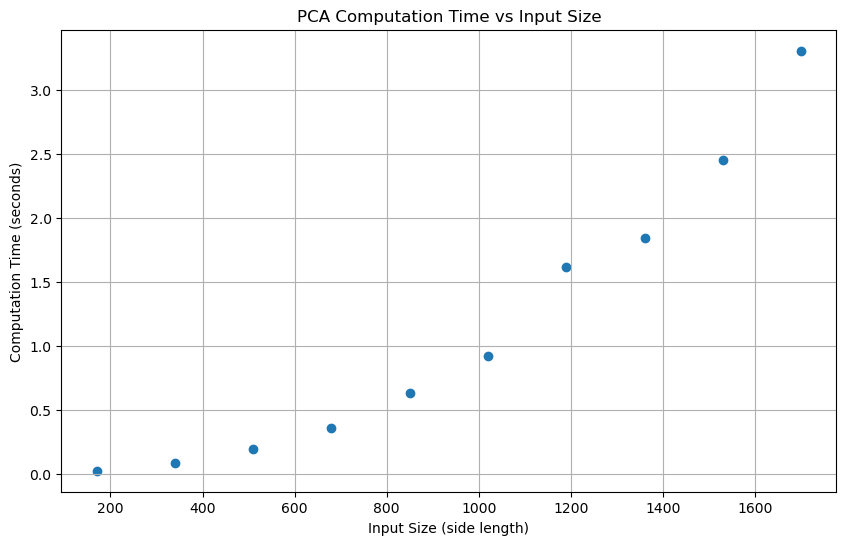

In [118]:


# Create a 2D square grid of random standard normal values
random_grid = np.random.standard_normal((500, 500))
# Initialize lists to store side lengths and computation times
side_lengths = []
computation_times = []

# Loop over side lengths from 170 to 170*100
for side_length in range(170, 170*11, 170):
  # Create a 2D square grid of random standard normal values
  random_grid = np.random.standard_normal((side_length, side_length))
  
  # Time the PCA computation
  start_time = time.time()
  
  # Run PCA
  pca = PCA()
  pca.fit(random_grid)
  
  end_time = time.time()
  
  # Record the side length and computation time
  side_lengths.append(side_length)
  computation_times.append(end_time - start_time)
  
  # Print the side length and time taken
  print(f"Side length: {side_length}, PCA computation time: {end_time - start_time} seconds")

# Plot the input size versus time scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(side_lengths, computation_times, marker='o')
plt.xlabel('Input Size (side length)')
plt.ylabel('Computation Time (seconds)')
plt.title('PCA Computation Time vs Input Size')
plt.grid(True)
plt.show()